<a href="https://colab.research.google.com/github/yesjiyoung/TeamProject_HosipitalManagementState/blob/main/hospital_management_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <병원 개/폐업 데이터 분석> : 병원의 회계데이터를 기반으로 지속 경영 여부를 분류예측하기

- Professor
  * 한양대학교 ERICA, 산업경영공학과 허선 교수님 
- Team member 
  * 산업경영공학과 노지영
  * 산업경영공학과 구건호
  * 산업경영공학과 정우석
  * 산업경영공학과 김용빈
  * 소프트웨어학과 윤병서
- Characteristics of the dataset 
  * 타입 : Multivariate
  * 레코드 : 428개 
  * 피쳐 : 58개 (Target var : ‘OC’ , predictors : 57개)
  * 타겟 변수의 클래스 불균형 : 개업 데이터와 폐업 데이터의 비율 -> 92:8
  * 2016, 2017 데이터의 변동성 반영 : 연도 별 데이터가 혼재되어있음 -> 2017-2016 파생데이터 생성
  
- Evalutaion scale 
  * recall
  * F1socre
  * AUCscore

#1.문제정의

- 한국의 핀테크 기업인 모우다(MOUDA)는 상환 기간 동안의 계속 경영 여부를 예측하여 신용 점수가 낮거나 담보를 가지지 못하는 우수 병원들에게 금융 기회를 제공하려 한다.


- 기업 모우다의 원금 손실을 줄이고자 폐업을 할 병원을 예측한다. 이를 위해 다양한 분류모델을 적용하고 최고의 F1-Score, AUC값이 나오는 모델을 선택하도록 한다.



# 2.데이터탐색(EDA)


## 2.1 데이터셋 구조 파악

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('raw_data.csv')
df = pd.DataFrame(df)

In [ ]:
df.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228.0,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,225169678.0,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.0,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,207829685.0,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401.0,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228.0,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,41864754.0,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814.0,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,902830288.0,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.0,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,838387466.0,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901.0,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,80749696.0,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.0,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,32642585.0,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


In [ ]:
# 데이터의 타입을 체크한다.
# 레코드:428개 피쳐:58개 (target var : 'OC', predictors : 57개)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             428 non-null    int64  
 1   OC                  428 non-null    object 
 2   sido                428 non-null    object 
 3   sgg                 428 non-null    int64  
 4   openDate            427 non-null    float64
 5   bedCount            415 non-null    float64
 6   instkind            425 non-null    object 
 7   revenue1            418 non-null    float64
 8   salescost1          418 non-null    float64
 9   sga1                418 non-null    float64
 10  salary1             418 non-null    float64
 11  noi1                418 non-null    float64
 12  noe1                418 non-null    float64
 13  interest1           418 non-null    float64
 14  ctax1               418 non-null    float64
 15  profit1             418 non-null    float64
 16  liquidAs

##2.2 기술통계량

In [ ]:
df.describe()

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
count,428.000000,428.000000,4.270000e+02,415.000000,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,410.000000,400.000000
mean,215.154206,85.436916,2.005034e+07,153.474699,1.448543e+10,2.600554e+09,1.125100e+10,6.180720e+09,3.437587e+08,6.188967e+08,2.257509e+08,8.935490e+07,2.651644e+08,3.800178e+09,3.659224e+09,7.492878e+08,1.342707e+08,1.279572e+10,1.183862e+10,3.598601e+08,9.612425e+05,1.014456e+10,5.099996e+09,2.107920e+09,5.234815e+09,3.112421e+09,6.175341e+09,1.481226e+09,1.319103e+10,2.380418e+09,1.007089e+10,5.504214e+09,2.855701e+08,6.291298e+08,2.184204e+08,7.226584e+07,3.253740e+08,3.488588e+09,3.353887e+09,6.336579e+08,1.246209e+08,1.159619e+10,1.076116e+10,3.316925e+08,1.619825e+05,9.268181e+09,4.390742e+09,1.710907e+09,5.076444e+09,3.240094e+09,5.525791e+09,1.178941e+09,160.456098,149.697500
std,124.453370,51.867136,8.854755e+04,121.469400,2.429913e+10,9.986687e+09,1.684542e+10,9.483958e+09,9.418323e+08,1.335157e+09,3.444631e+08,2.682287e+08,1.373525e+09,6.682408e+09,6.470950e+09,1.721884e+09,2.767994e+08,1.892751e+10,1.761218e+10,9.739191e+08,1.631077e+07,1.553113e+10,8.355798e+09,4.105065e+09,8.916033e+09,5.126111e+09,1.198735e+10,7.548149e+09,2.257143e+10,9.104843e+09,1.546733e+10,8.733907e+09,7.271677e+08,1.320242e+09,3.830729e+08,2.370850e+08,1.316972e+09,6.582253e+09,6.359864e+09,1.584505e+09,2.680708e+08,1.829542e+10,1.715745e+10,9.086105e+08,3.193096e+06,1.513045e+10,7.795737e+09,3.673698e+09,9.220942e+09,5.661182e+09,1.051916e+10,4.720339e+09,202.896891,182.906706
min,1.000000,1.000000,1.976041e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.734451e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.019624e+10,-8.636718e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.645265e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.014780e+10,-8.600000e+09,0.000000,0.000000
25%,107.750000,37.750000,2.001025e+07,63.000000,3.238344e+09,0.000000e+00,2.880497e+09,1.629412e+09,9.943713e+06,8.032983e+07,5.149973e+07,0.000000e+00,0.000000e+00,7.493618e+08,7.129472e+08,7.493450e+04,3.387425e+06,3.415747e+09,3.012105e+09,1.953452e+06,0.000000e+00,2.033662e+09,5.294816e+08,0.000000e+00,5.930316e+08,0.000000e+00,1.381459e+09,0.000000e+00,2.785462e+09,0.000000e+00,2.298428e+09,1.352012e+09,6.499917e+06,6.147118e+07,3.303029e+07,0.000000e+00,0.000000e+00,4.521446e+08,4.288854e+08,0.000000e+00,5.694805e+05,2.492128e+09,2.399974e+09,0.000000e+00,0.000000e+00,1.332548e+09,3.006586e+08,0.000000e+00,2.597232e+07,0.000000e+00,9.690131e+08,0.000000e+00,54

## 2.3 단변량


1.   target variable
2.   categorical variables
3.   numerical variables




In [ ]:
#전체 변수들의 리스트 
column_names = list(df) 

#Categorical variables(범주형변수)
categorical_vars = ['OC', 'sido', 'instkind', 'ownerChange'] 

#Numerical variables(수치형변수)
numerical_vars = [x for x in column_names if x not in categorical_vars] # column_names 와 categorical_vars 의 차집합.

#final_data = 범주형 + 수치형 = 전체 데이터셋
final_data = df[categorical_vars + numerical_vars]

In [ ]:
final_data = pd.DataFrame(final_data)

In [ ]:
final_data.head()

,OC,sido,instkind,ownerChange,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
0,open,choongnam,nursing_hospital,same,1,73,20071228.0,175.0,4.217530e+09,0.0,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,225169678.0,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.0,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,207829685.0,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0
1,open,gyeongnam,general_hospital,same,3,32,19970401.0,410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0
2,open,gyeonggi,nursing_hospital,same,4,89,20161228.0,468.0,1.004522e+09,515483669.0,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,41864754.0,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0
3,open,incheon,general_hospital,same,7,141,20000814.0,353.0,7.250734e+10,0.0,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,902830288.0,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.0,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,838387466.0,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0
4,open,gyeongnam,general_hospital,same,9,32,20050901.0,196.0,4.904354e+10,0.0,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,80749696.0,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.0,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,32642585.0,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0


### -Target variable

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


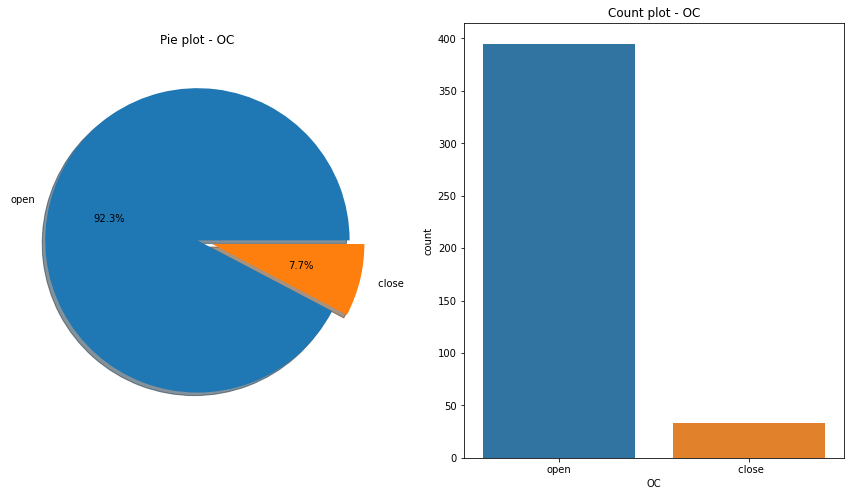

In [ ]:
#Target variable 시각화
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize = (15,8))
final_data['OC'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow = True)
ax[0].set_title('Pie plot - OC')
ax[0].set_ylabel('')
sns.countplot('OC', data=final_data, ax=ax[1])
ax[1].set_title('Count plot - OC')
plt.show()

###-Categorical variables

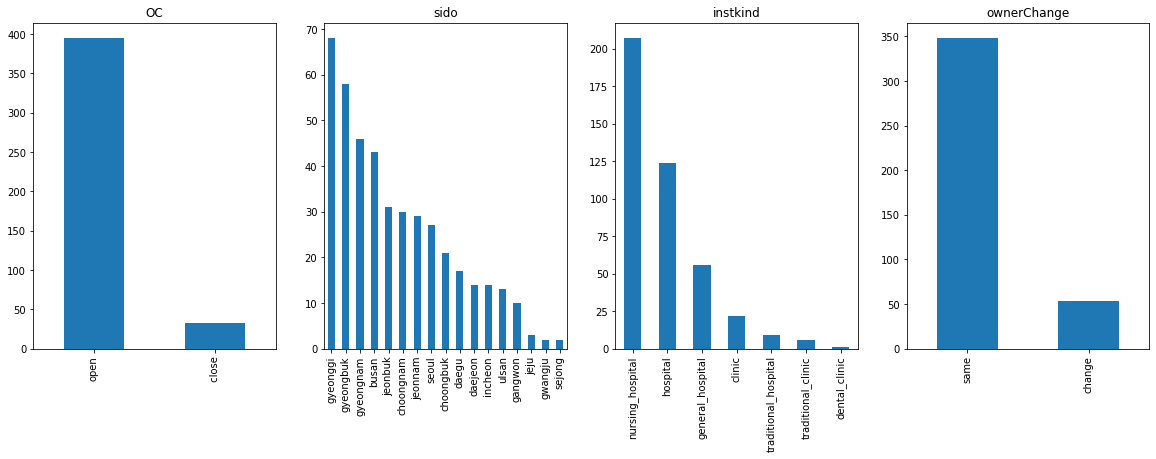

In [ ]:
#Categorical variable 시각화
fig, ax = plt.subplots(1,4,figsize=(20,6))
for var, subplot in zip(categorical_vars, ax.flatten()):
    final_data[var].value_counts().plot(kind='bar',ax=subplot, title=var)
plt.show()

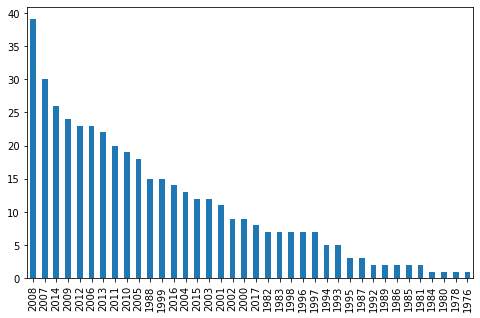

In [ ]:
# 비록 수치형이지만, 범주형 데이터로 변경 후, 시각화
plt.figure(figsize=(8,5))
final_data['openDate'].astype('string').str[0:4].dropna(axis=0).astype(int).value_counts().plot(kind='bar')

###-Numerical Variables


*   'bedCount'
*   '~1' 2017회계데이터
*   '~2' 2016회계데이터
*   '~3' (2017-2016)회계데이터 



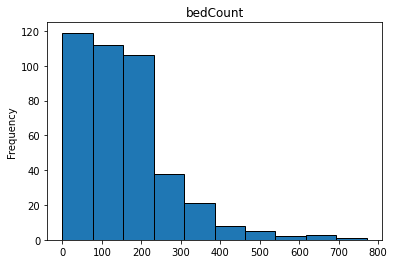

In [ ]:
 final_data['bedCount'].plot(kind='hist', title='bedCount', edgecolor='black')

In [ ]:
# 회계 데이터는 모두 수치형 변수
# 회계데이터들의 차이를 파생변수로 생성하기 위해, 회계 데이터들을2017년 - 2016년을 해줌.
# 2017 회계 데이터 'revenue1', 'salecost1'과 같이 변수name 끝에 1이 들어가는 변수 
# 2016 회계 데이터 'revenue2', 'salecost2'과 같이 변수name 끝에 2이 들어가는 변수 
accounting_var_2017 = [] # 2017 회계 피쳐들을 담을 빈 리스트 형성
accounting_var_2016 = [] # 2016 회계 피쳐들을 담을 빈 리스트 형성

for var in numerical_vars :
  if ( var.find('1') != -1 ): # 변수 name에 '1'이 있으면, accounting_var_2017 리스트에 넣어줌
    accounting_var_2017.append(var)
  if ( var.find('2') != -1 ): # 변수 name에 '2'가 있으면, accounting_var_2016 리스트에 넣어줌
    accounting_var_2016.append(var)

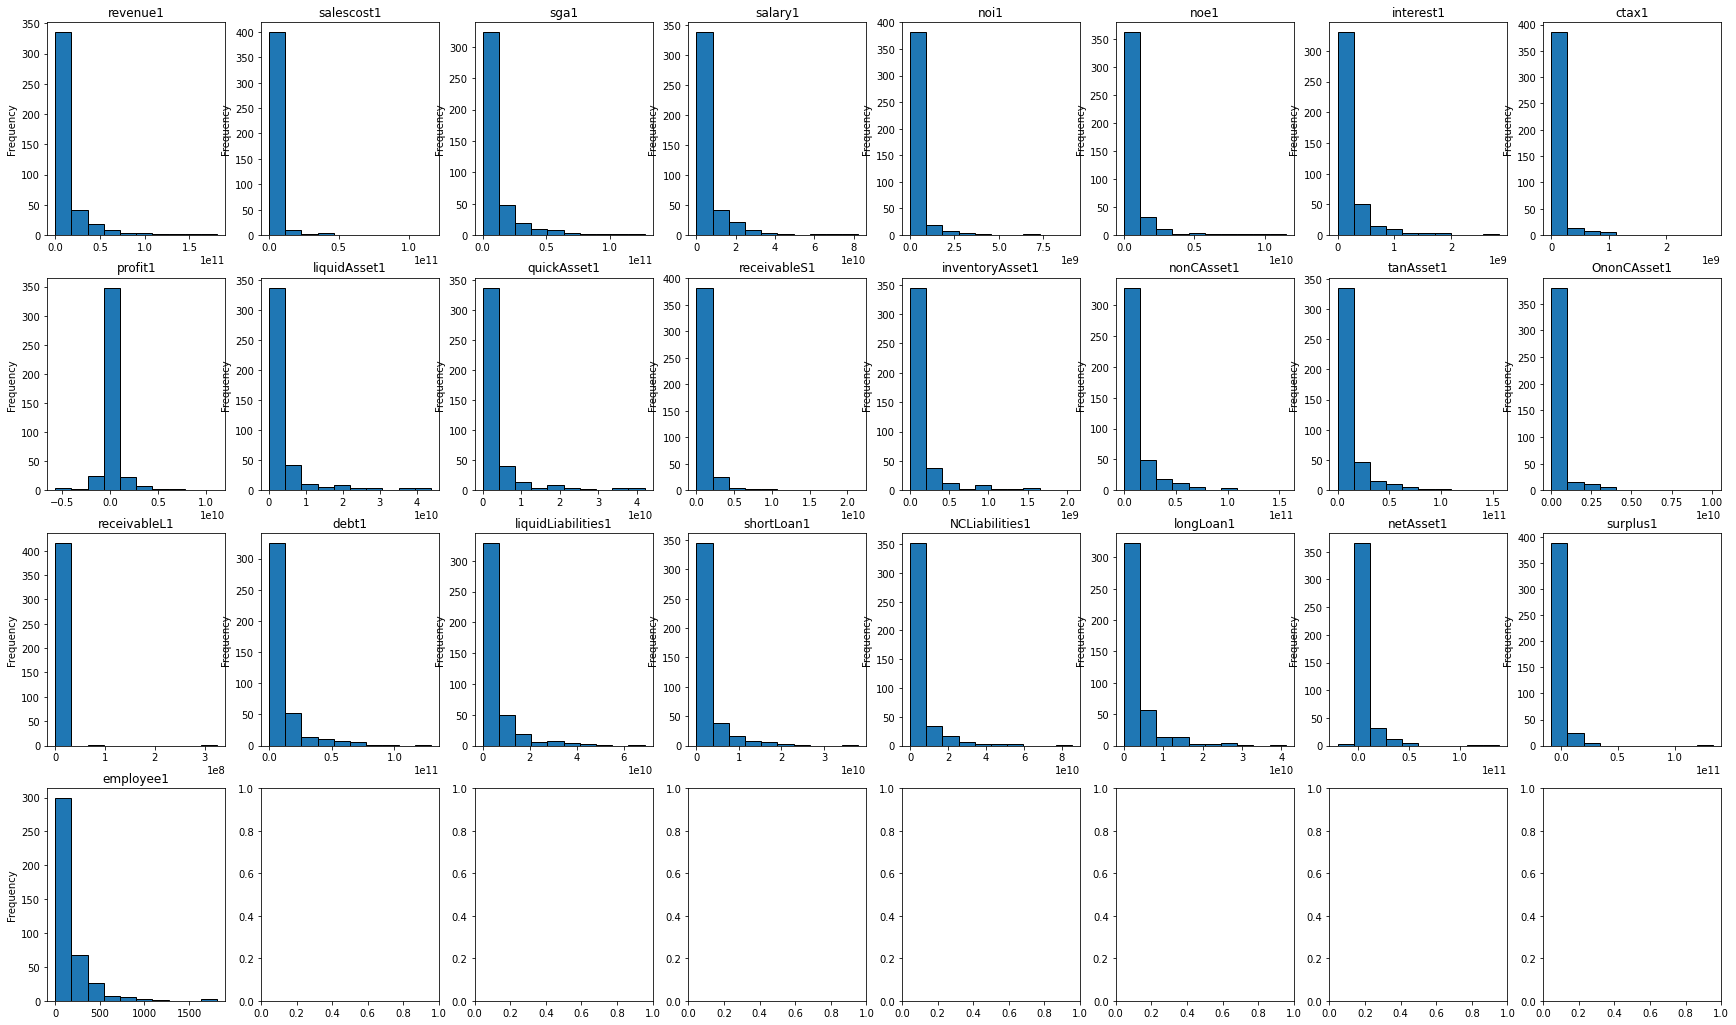

In [ ]:
# 2017 회계 데이터 시각화
fig, ax = plt.subplots(4,8)

fig.set_size_inches((30,18))
for var, subplot in zip(accounting_var_2017,ax.flatten()):

  final_data[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

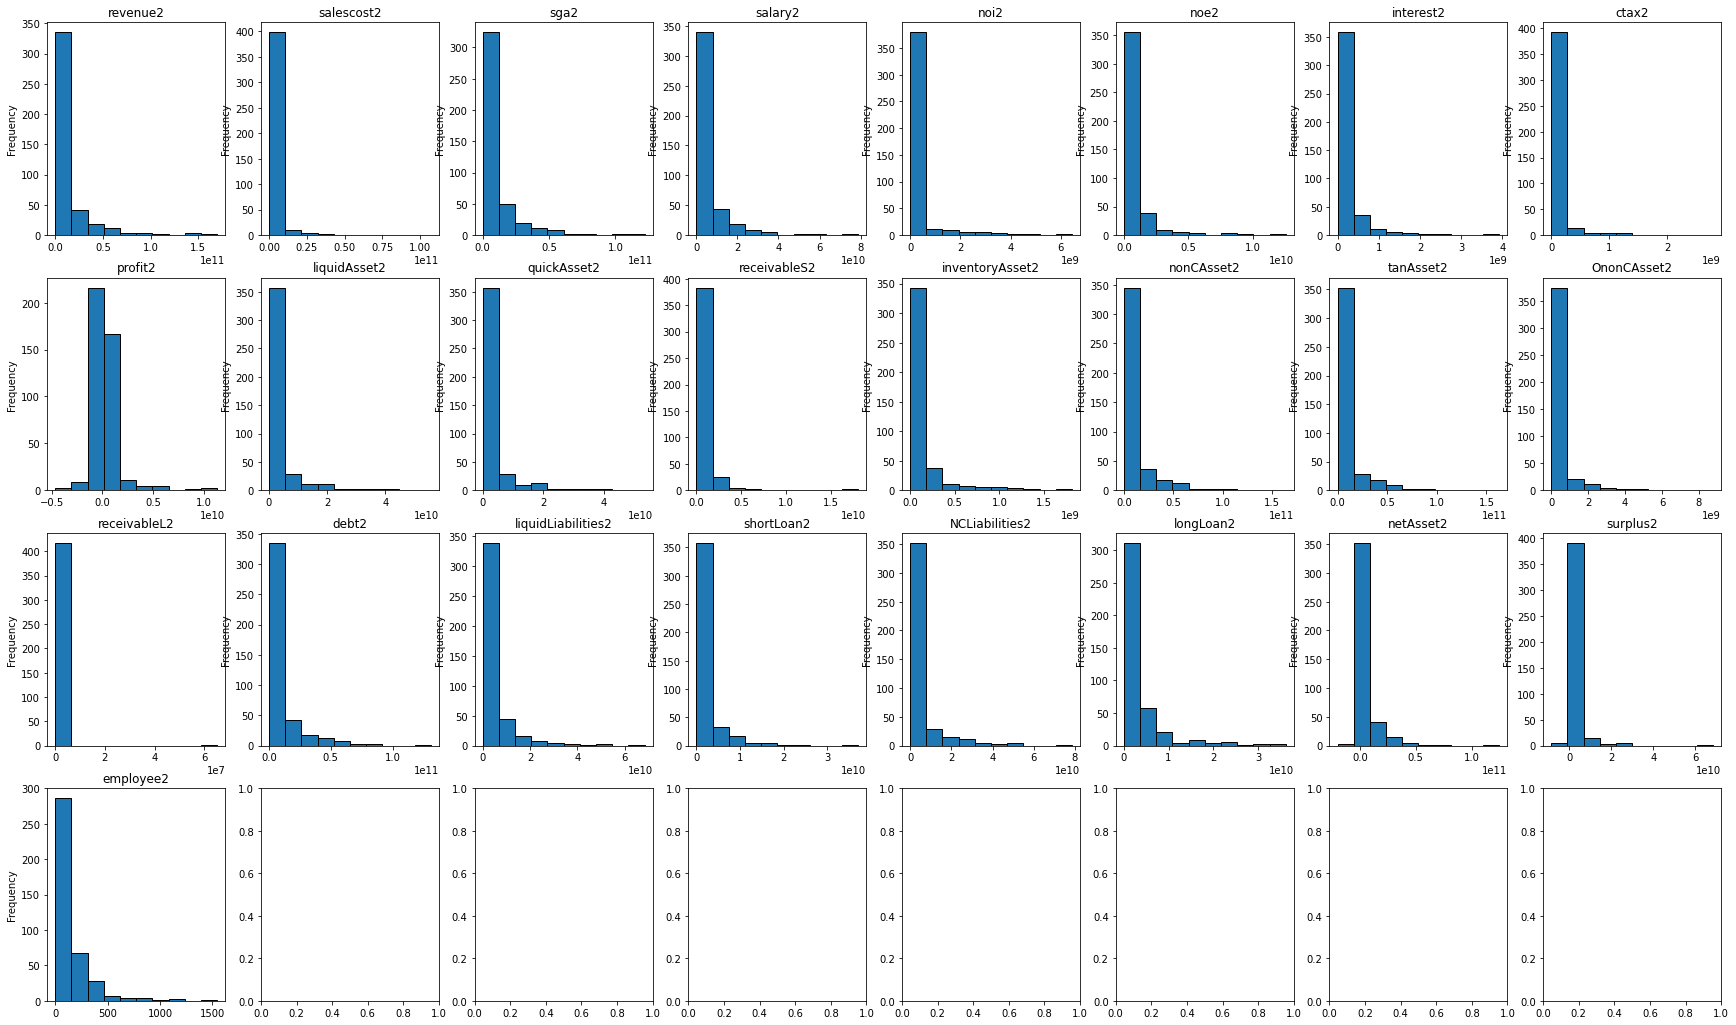

In [ ]:
# 2016 회계 데이터 시각화
fig, ax = plt.subplots(4,8)

fig.set_size_inches((30,18))
for var, subplot in zip(accounting_var_2016,ax.flatten()):

  final_data[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

In [ ]:
accounting_difference_2017_2016 = [] # 파생변수들을 담을 빈 리스트 생성

for i in range(0,len(accounting_var_2016)):
  new_name = accounting_var_2017[i].replace("1","3")
  accounting_difference_2017_2016.append(new_name)
  final_data[new_name] = final_data[accounting_var_2017[i]] - final_data[accounting_var_2016[i]] # 각각 빼주고, 리스트에 넣어줌 

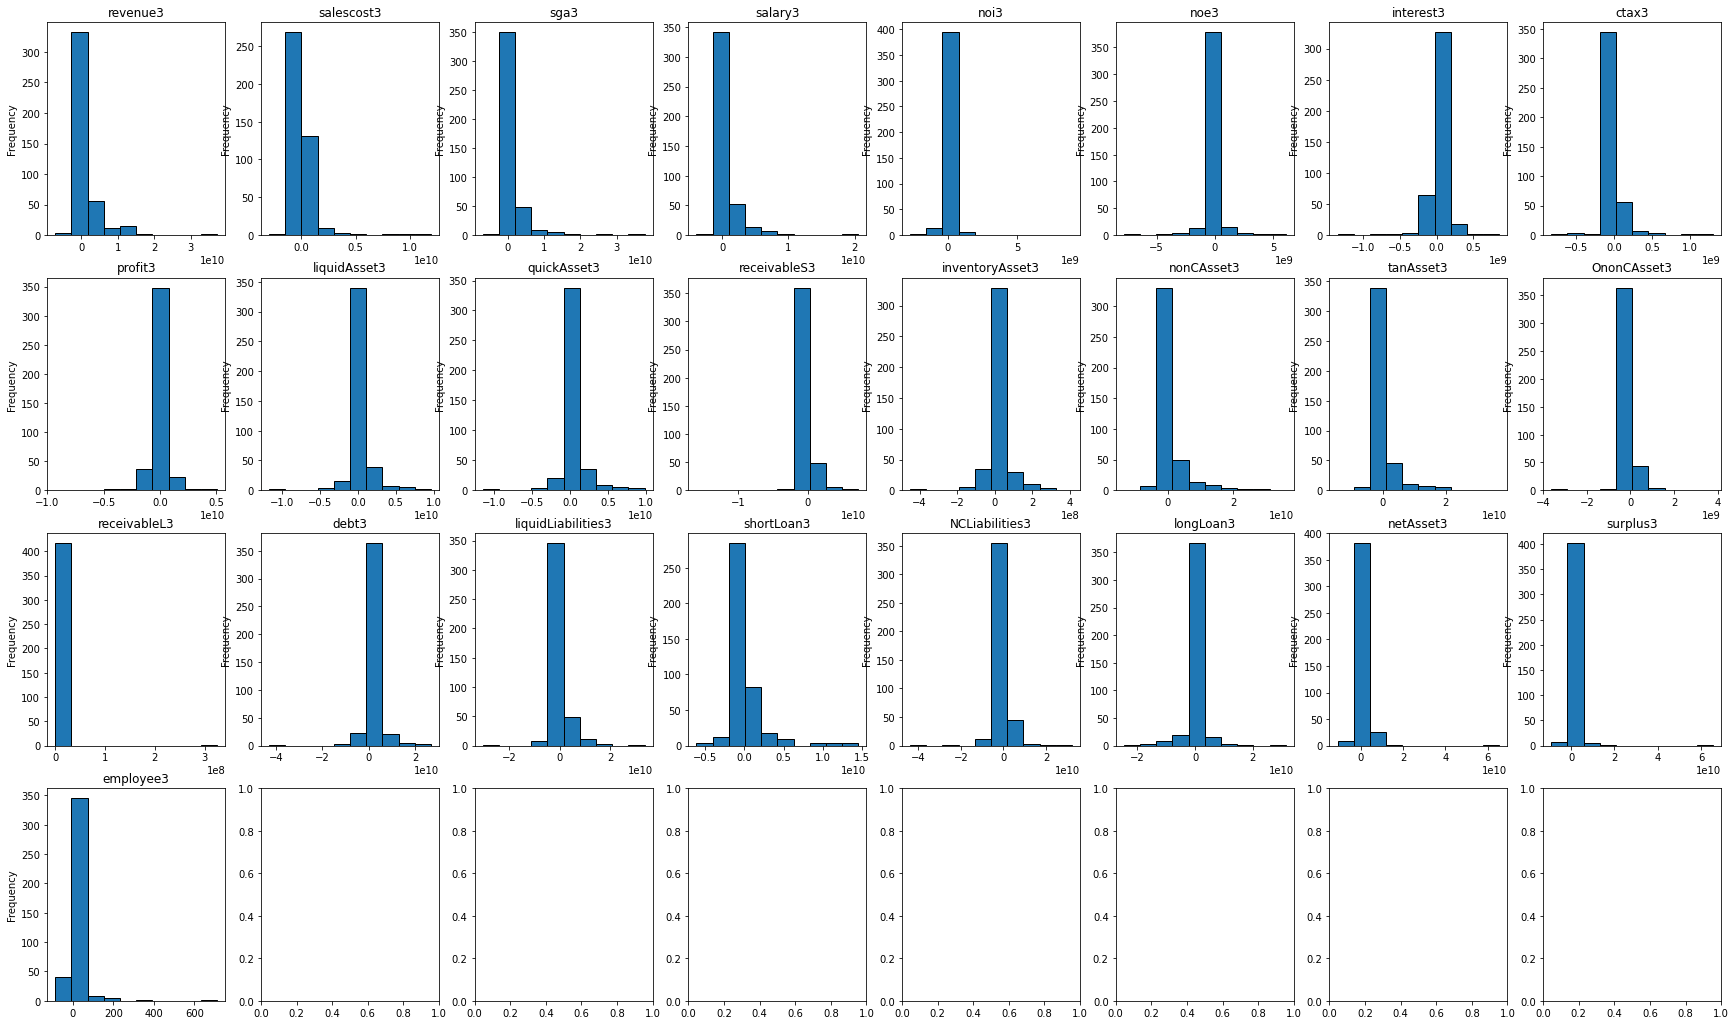

In [ ]:
# 2017 - 2016 회계 데이터 시각화
fig, ax = plt.subplots(4,8)

fig.set_size_inches((30,18))
for var, subplot in zip(accounting_difference_2017_2016,ax.flatten()):

  final_data[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

##2.4 다변량

###-Categorical - target

In [ ]:
copy_final_data = final_data

In [ ]:
copy_final_data['openDate']=final_data['openDate'].astype('string').str[0:4] # 수치형 -> 명목형

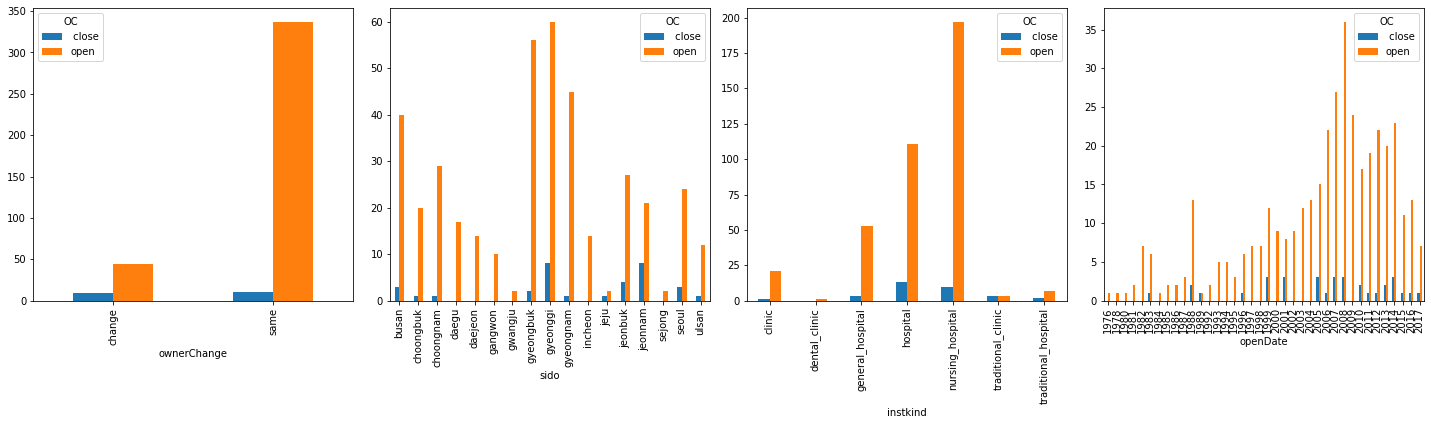

In [ ]:
# 범주형 변수 시각화
fig, ax = plt.subplots(1,4, figsize=(20,6))
for var, subplot in zip(['ownerChange','sido','instkind','openDate'], ax.flatten()):
    copy_final_data.groupby([var,'OC'])['OC'].count().unstack('OC').plot(kind='bar', ax=subplot)
fig.tight_layout()
plt.show()

###-Numerical - target

In [ ]:
bedCount = ['bedCount']
df_c = final_data[categorical_vars + bedCount + accounting_difference_2017_2016]


In [ ]:
# 타겟 범주형 변수 -> 정수화
df_c.loc[df_c["OC"]== " close", "OC"] = 1
df_c.loc[df_c["OC"]=="open", "OC"] = 0
df_c['OC'] = df_c['OC'].astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
corr_df = df_c.corr()
corr_df

,OC,bedCount,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
OC,1.000000,0.010066,-0.029590,0.030068,-0.050391,-0.034919,0.026477,-0.049665,-0.087376,-0.044167,0.099773,-0.072701,-0.076484,0.008397,0.067598,0.020641,0.008207,-0.020219,-0.009974,-0.041876,-0.033148,-0.044271,-0.009095,0.017861,0.038261,0.037346,0.011149
bedCount,0.010066,1.000000,0.226907,0.088802,0.231349,0.292008,0.096033,0.003640,0.037987,0.129316,-0.034198,-0.053550,-0.051855,0.037310,0.090719,0.185319,0.182440,0.041280,-0.056724,0.194070,0.127671,0.172969,0.084069,-0.056675,-0.008189,-0.032681,0.200774
revenue3,-0.029590,0.226907,1.000000,0.486805,0.899264,0.918199,-0.110105,-0.030883,0.174016,0.255383,-0.081622,0.343481,0.344899,0.104835,0.074073,0.472894,0.446551,0.152573,-0.016666,0.356506,0.437028,0.217827,-0.023333,-0.068697,0.307239,0.161174,0.401330
salescost3,0.030068,0.088802,0.486805,1.000000,0.207934,0.219050,-0.013659,-0.076748,0.055966,-0.014481,-0.065931,-0.042074,-0.033935,0.057376,-0.045611,0.223102,0.189273,0.125250,-0.010012,0.160128,0.155871,0.082877,0.027695,-0.019140,0.070899,0.058152,0.202781
sga3,-0.050391,0.231349,0.899264,0.207934,1.000000,0.933204,-0.098418,-0.185819,0.190672,0.195776,-0.334028,0.360720,0.359435,0.137348,0.110308,0.455210,0.434841,0.155564,-0.011436,0.214288,0.369202,0.158703,-0.109059,-0.014726,0.440102,0.333128,0.282779
salary3,-0.034919,0.292008,0.918199,0.219050,0.933204,1.000000,-0.084068,-0.046433,0.189227,0.222802,-0.147170,0.304002,0.299783,0.067631,0.140798,0.446302,0.438760,0.133859,-0.015558,0.371198,0.393761,0.183016,0.029686,-0.037244,0.246074,0.105593,0.351837
noi3,0.026477,0.096033,-0.110105,-0.013659,-0.098418,-0.084068,1.000000,0.510119,0.008891,-0.054591,0.251907,-0.062359,-0.064396,0.144766,0.033524,-0.030276,0.006650,-0.020596,-0.004275,0.004392,-0.132527,-0.075527,0.123512,-0.126100,-0.065149,-0.104058,0.007800
noe3,-0.049665,0.003640,-0.030883,-0.076748,-0.185819,-0.046433,0.510119,1.000000,0.105820,0.012534,0.167710,0.169733,0.168155,0.033756,0.007088,-0.076695,-0.039615,-0.038879,-0.000636,0.389720,0.094409,0.165581,0.313958,-0.112033,-0.417595,-0.432256,0.033745
interest3,-0.087376,0.037987,0.174016,0.055966,0.190672,0.189227,0.008891,0.105820,1.000000,0.013135,-0.171296,0.047950,0.040926,0.010488,0.229346,0.300208,0.313236,-0.175323,-0.000539,0.286352,-0.103696,-0.156998,0.387409,0.411111,0.060252,-0.012712,-0.007806
ctax3,-0.044167,0.129316,0.255383,-0.014481,0.195776,0.222802,-0.054591,0.012534,0.013135,1.000000,0.094716,0.265209,0.267814,0.037857,-0.042217,0.014698,0.007725,-0.038568,-0.006461,0.031486,0.170933,0.110029,-0.120814,-0.246887,0.095715,0.058307,0.473202


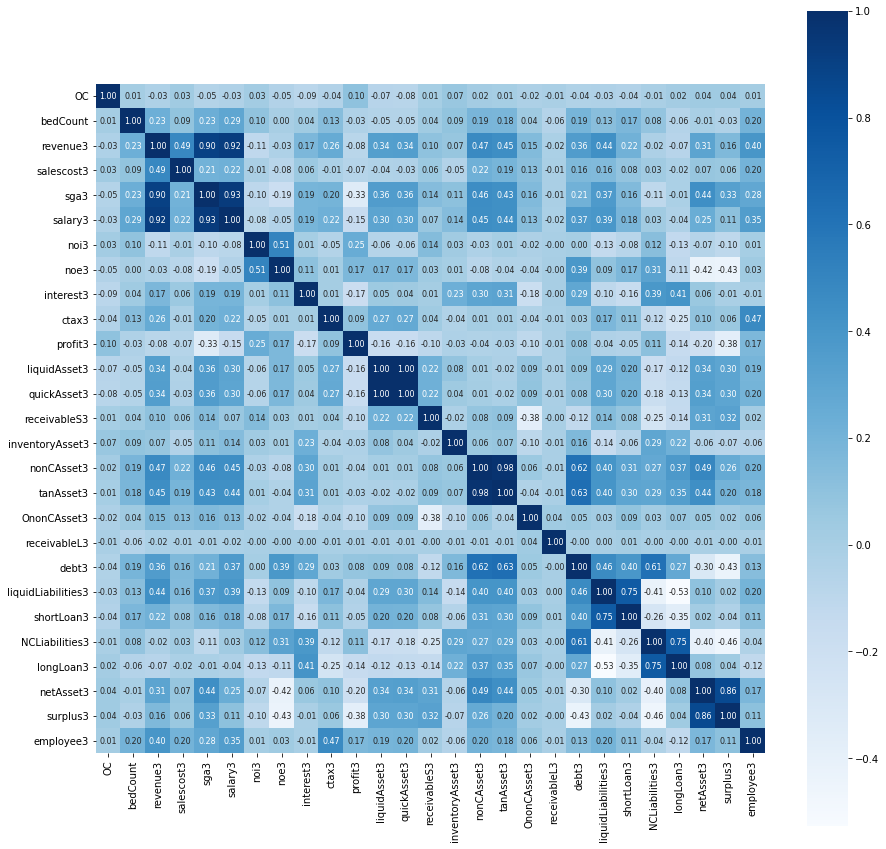

In [ ]:
# 변수간의 상관관계 히트맵
plt.figure(figsize=(15,15))
sns.heatmap(corr_df, cbar = True, annot = True , annot_kws={'size' :8},
            fmt = '.2f' , square = True, cmap = 'Blues')

##2.5  가설설정




- 데이터 탐색을 통해 Ownerchange(대표자의 변동 여부) 및 2016년 대비 2017년의 profit(당기순이익) 증감이 병원 개/폐업에 영향을 미칠 것이다. 
- 도메인 지식을 활용하여 debt(부채총계), interest(이자비용), employee(직원수)의 증감 역시 병원 개/폐업에 영향을 미칠 것이라 판단하여 이 역시 추후 모델링 과정을 통해 검증할 것이다.



#3.데이터전처리[1차+모델링]



## 3.1 파생변수 생성


In [ ]:
import pandas as pd 

df = pd.read_csv('raw_data.csv')
df = pd.DataFrame(df)
# 전체 column 이름들 
column_names = list(df) 

#Categorical variables(범주형변수) 
categorical_vars = ['OC', 'sido', 'instkind', 'ownerChange']

#Numerical variables(수치형변수)
numerical_vars = [x for x in column_names if x not in categorical_vars] # column_names 와 categorical_vars 의 차집합.

final_data = df[categorical_vars + numerical_vars]
final_data = pd.DataFrame(final_data)

In [ ]:
# 회계 데이터는 모두 수치형 변수
# 회계데이터들의 차이를 파생변수로 생성하기 위해, 회계 데이터들을2017년 - 2016년을 해줌.
# 2017 회계 데이터 'revenue1', 'salecost1'과 같이 변수name 끝에 1이 들어가는 변수 
# 2016 회계 데이터 'revenue2', 'salecost2'과 같이 변수name 끝에 2이 들어가는 변수 
accounting_var_2017 = [] # 2017 회계 피쳐들을 담을 빈 리스트 형성
accounting_var_2016 = [] # 2016 회계 피쳐들을 담을 빈 리스트 형성

for var in numerical_vars :
  if ( var.find('1') != -1 ): # 변수 name에 '1'이 있으면, accounting_var_2017 리스트에 넣어줌
    accounting_var_2017.append(var)
  if ( var.find('2') != -1 ): # 변수 name에 '2'가 있으면, accounting_var_2016 리스트에 넣어줌
    accounting_var_2016.append(var)

In [ ]:
accounting_difference_2017_2016 = [] # 파생변수들을 담을 빈 리스트 생성

for i in range(0,len(accounting_var_2016)):
  new_name = accounting_var_2017[i].replace("1","3")
  accounting_difference_2017_2016.append(new_name)
  final_data[new_name] = final_data[accounting_var_2017[i]] - final_data[accounting_var_2016[i]] # 각각 빼주고, 리스트에 넣어줌 

In [ ]:
li = ['bedCount', 'openDate', 'sgg']
real_final_data = final_data[categorical_vars +li+ accounting_difference_2017_2016]
real_final_data # 총 레코드 428개 # 피쳐 32개 

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
0,open,choongnam,nursing_hospital,same,175.0,20071228.0,73,-8.031824e+07,0.000000e+00,-9.628707e+07,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,1.811014e+08,-53646830.0,1428837.0,-3.352830e+07,-2.557930e+07,-2449000.0,0.0,-7.616775e+07,-2.155316e+07,0.000000e+00,-5.461460e+07,-3.900000e+07,2.251697e+08,225169678.0,-2.0
1,open,gyeongnam,general_hospital,same,410.0,19970401.0,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.0
2,open,gyeonggi,nursing_hospital,same,468.0,20161228.0,89,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,2.536822e+08,8095950.0,18759968.0,1.204810e+08,1.204810e+08,0.0,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.0,233.0
3,open,incheon,general_hospital,same,353.0,20000814.0,141,5.649006e+09,0.000000e+00,5.753205e+09,2.074703e+09,29415255.0,-94104842.0,-80540715.0,-45121940.0,64442822.0,1.915823e+09,1.644210e+09,0.0,271612480.0,3.595795e+09,3.465022e+09,29302018.0,0.0,4.608787e+09,1.097328e+10,1.066577e+10,-6.364497e+09,-7.846960e+09,9.028303e+08,902830288.0,0.0
4,open,gyeongnam,general_hospital,same,196.0,20050901.0,32,9.607370e+08,0.000000e+00,5.302526e+08,1.000740e+09,-485395869.0,-103018625.0,-42602315.0,0.0,48107111.0,1.410308e+09,1.409248e+09,734093256.0,1059446.0,-2.864045e+09,-2.323317e+09,-567000700.0,0.0,-1.534487e+09,-1.163398e+09,3.366231e+08,-3.710896e+08,-6.080275e+08,8.074970e+07,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,close,jeonnam,traditional_clinic,NaN,0.0,20011012.0,33,-6.478885e+07,-7.428410e+05,4.375277e+08,9.335632e+08,-59818683.0,-269660838.0,-153130496.0,-137857554.0,-153873997.0,1.204736e+09,1.165499e+09,644261571.0,39237644.0,6.826569e+08,9.263251e+08,2000000.0,0.0,1.951897e+08,-2.207433e+07,0.000000e+00,2.172640e+08,0.000000e+00,1.692204e+09,0.0,NaN
424,close,gyeonggi,traditional_hospital,same,NaN,20010530.0,74,-7.759709e+08,0.000000e+00,-6.460058e+08,-4.263722e+08,-9779723.0,-53108189.0,-35378688.0,528685902.0,-615322508.0,-8.826843e+08,-8.826843e+08,-133178510.0,0.0,6.249577e+08,5.187377e+08,106220000.0,0.0,-1.237918e+09,5.165253e+08,0.000000e+00,-1.754443e+09,-1.740000e+09,9.801914e+08,980191435.0,-5.0
425,close,gyeonggi,hospital,NaN,150.0,20010101.0,116,1.170330e+09,9.688405e+07,8.814367e+08,6.235152e+08,-98769400.0,50608589.0,157710291.0,517770.0,42113908.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN
426,open,jeju,NaN,same,NaN,20010201.0,76,1.342325e+09,1.412956e+09,-3.397334e+08,1.102062e+08,-14697359.0,-4344458.0,-5412045.0,31802061.0,226947698.0,2.434632e+09,2.295529e+09,0.0,139103387.0,3.696290e+08,9.131159e+08,424569085.0,0.0,1.386918e+09,8.568958e+08,0.000000e+00,5.300218e+08,0.000000e+00,1.417343e+09,0.0,20.0


In [ ]:
real_final_data

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
0,open,choongnam,nursing_hospital,same,175.0,20071228.0,73,-8.031824e+07,0.000000e+00,-9.628707e+07,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,1.811014e+08,-53646830.0,1428837.0,-3.352830e+07,-2.557930e+07,-2449000.0,0.0,-7.616775e+07,-2.155316e+07,0.000000e+00,-5.461460e+07,-3.900000e+07,2.251697e+08,225169678.0,-2.0
1,open,gyeongnam,general_hospital,same,410.0,19970401.0,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.0
2,open,gyeonggi,nursing_hospital,same,468.0,20161228.0,89,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,2.536822e+08,8095950.0,18759968.0,1.204810e+08,1.204810e+08,0.0,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.0,233.0
3,open,incheon,general_hospital,same,353.0,20000814.0,141,5.649006e+09,0.000000e+00,5.753205e+09,2.074703e+09,29415255.0,-94104842.0,-80540715.0,-45121940.0,64442822.0,1.915823e+09,1.644210e+09,0.0,271612480.0,3.595795e+09,3.465022e+09,29302018.0,0.0,4.608787e+09,1.097328e+10,1.066577e+10,-6.364497e+09,-7.846960e+09,9.028303e+08,902830288.0,0.0
4,open,gyeongnam,general_hospital,same,196.0,20050901.0,32,9.607370e+08,0.000000e+00,5.302526e+08,1.000740e+09,-485395869.0,-103018625.0,-42602315.0,0.0,48107111.0,1.410308e+09,1.409248e+09,734093256.0,1059446.0,-2.864045e+09,-2.323317e+09,-567000700.0,0.0,-1.534487e+09,-1.163398e+09,3.366231e+08,-3.710896e+08,-6.080275e+08,8.074970e+07,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,close,jeonnam,traditional_clinic,NaN,0.0,20011012.0,33,-6.478885e+07,-7.428410e+05,4.375277e+08,9.335632e+08,-59818683.0,-269660838.0,-153130496.0,-137857554.0,-153873997.0,1.204736e+09,1.165499e+09,644261571.0,39237644.0,6.826569e+08,9.263251e+08,2000000.0,0.0,1.951897e+08,-2.207433e+07,0.000000e+00,2.172640e+08,0.000000e+00,1.692204e+09,0.0,NaN
424,close,gyeonggi,traditional_hospital,same,NaN,20010530.0,74,-7.759709e+08,0.000000e+00,-6.460058e+08,-4.263722e+08,-9779723.0,-53108189.0,-35378688.0,528685902.0,-615322508.0,-8.826843e+08,-8.826843e+08,-133178510.0,0.0,6.249577e+08,5.187377e+08,106220000.0,0.0,-1.237918e+09,5.165253e+08,0.000000e+00,-1.754443e+09,-1.740000e+09,9.801914e+08,980191435.0,-5.0
425,close,gyeonggi,hospital,NaN,150.0,20010101.0,116,1.170330e+09,9.688405e+07,8.814367e+08,6.235152e+08,-98769400.0,50608589.0,157710291.0,517770.0,42113908.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN
426,open,jeju,NaN,same,NaN,20010201.0,76,1.342325e+09,1.412956e+09,-3.397334e+08,1.102062e+08,-14697359.0,-4344458.0,-5412045.0,31802061.0,226947698.0,2.434632e+09,2.295529e+09,0.0,139103387.0,3.696290e+08,9.131159e+08,424569085.0,0.0,1.386918e+09,8.568958e+08,0.000000e+00,5.300218e+08,0.000000e+00,1.417343e+09,0.0,20.0


## 3.2Null처리

* 행의 80% 이상이 Null값인 경우 행 자체를 제거함.

* 수치형 변수의 경우 Null값을 평균값으로 대체함.

* instkind와 ownerChange의 경우 수치형이 아니므로 최빈값으로 대체함.

In [ ]:
df = real_final_data

In [ ]:
# 데이터의 column별 null()값 확인
df.isnull().sum()

OC                     0
sido                   0
instkind               3
ownerChange           27
bedCount              13
openDate               1
sgg                    0
revenue3              10
salescost3            10
sga3                  10
salary3               10
noi3                  10
noe3                  10
interest3             10
ctax3                 10
profit3               10
liquidAsset3          10
quickAsset3           10
receivableS3          10
inventoryAsset3       10
nonCAsset3            10
tanAsset3             10
OnonCAsset3           10
receivableL3          10
debt3                 10
liquidLiabilities3    10
shortLoan3            10
NCLiabilities3        10
longLoan3             10
netAsset3             10
surplus3              10
employee3             29
dtype: int64

###-Null값이 대부분인 레코드 제거
- null값 확인 결과 revenue3 ~ employee3(회계데이터들)까지 null값을 가지고 있는 행이 전부 일치하여 null값을 가지고 있는 행 전부 제거 

In [ ]:
# null값 확인 결과 revenue3 ~ employee3까지 null값을 가지고 있는 행이 전부 일치하여 null값을 가지고 있는 행 전부 제거
not_null_df = df[df['revenue3'].notnull()]

###-수치형 피쳐 내부의 null값을 평균으로 대체
- bedCount, employee3, openDate의 null값을 평균으로 대체

In [ ]:
# bedCount, employee3, openDate의 null값을 평균으로 대체
import math 
bed_mean = math.floor(not_null_df['bedCount'].mean());
not_null_df['bedCount'] = not_null_df['bedCount'].fillna(bed_mean)

employee3_mean = math.floor(not_null_df['employee3'].mean());
not_null_df['employee3'] = not_null_df['employee3'].fillna(employee3_mean)

openDate_mean = math.floor(not_null_df['openDate'].mean()); 
not_null_df['openDate'] = not_null_df['openDate'].fillna(openDate_mean)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

###-범주형 피쳐 내부의 null값은 최빈값으로 대체
- instkind와 ownerChange의 null값을 최빈값으로 대체

In [ ]:
# instkind와 ownerChange의 null값을 최빈값으로 대체
not_null_df['instkind'] = not_null_df['instkind'].fillna('nursing_house')
not_null_df['ownerChange'] = not_null_df['ownerChange'].fillna('same')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df2 = not_null_df

In [ ]:
df2

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
0,open,choongnam,nursing_hospital,same,175.0,20071228.0,73,-8.031824e+07,0.000000e+00,-9.628707e+07,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,1.811014e+08,-53646830.0,1428837.0,-3.352830e+07,-2.557930e+07,-2449000.0,0.0,-7.616775e+07,-2.155316e+07,0.000000e+00,-5.461460e+07,-3.900000e+07,2.251697e+08,2.251697e+08,-2.0
2,open,gyeonggi,nursing_hospital,same,468.0,20161228.0,89,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,2.536822e+08,8095950.0,18759968.0,1.204810e+08,1.204810e+08,0.0,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,233.0
3,open,incheon,general_hospital,same,353.0,20000814.0,141,5.649006e+09,0.000000e+00,5.753205e+09,2.074703e+09,29415255.0,-94104842.0,-80540715.0,-45121940.0,64442822.0,1.915823e+09,1.644210e+09,0.0,271612480.0,3.595795e+09,3.465022e+09,29302018.0,0.0,4.608787e+09,1.097328e+10,1.066577e+10,-6.364497e+09,-7.846960e+09,9.028303e+08,9.028303e+08,0.0
4,open,gyeongnam,general_hospital,same,196.0,20050901.0,32,9.607370e+08,0.000000e+00,5.302526e+08,1.000740e+09,-485395869.0,-103018625.0,-42602315.0,0.0,48107111.0,1.410308e+09,1.409248e+09,734093256.0,1059446.0,-2.864045e+09,-2.323317e+09,-567000700.0,0.0,-1.534487e+09,-1.163398e+09,3.366231e+08,-3.710896e+08,-6.080275e+08,8.074970e+07,0.000000e+00,9.0
5,open,gyeongnam,general_hospital,same,243.0,20020501.0,155,-7.539098e+08,-6.161420e+08,-3.683077e+08,2.674107e+08,-60266829.0,291186440.0,-79048185.0,0.0,-120913329.0,7.656857e+08,7.558229e+08,465865678.0,9862851.0,-3.477443e+09,-3.361751e+09,-54587822.0,0.0,0.000000e+00,-3.361751e+09,9.339000e+07,-2.000000e+07,0.000000e+00,0.000000e+00,-2.214085e+09,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,close,jeonnam,traditional_clinic,same,0.0,20011012.0,33,-6.478885e+07,-7.428410e+05,4.375277e+08,9.335632e+08,-59818683.0,-269660838.0,-153130496.0,-137857554.0,-153873997.0,1.204736e+09,1.165499e+09,644261571.0,39237644.0,6.826569e+08,9.263251e+08,2000000.0,0.0,1.951897e+08,-2.207433e+07,0.000000e+00,2.172640e+08,0.000000e+00,1.692204e+09,0.000000e+00,10.0
424,close,gyeonggi,traditional_hospital,same,151.0,20010530.0,74,-7.759709e+08,0.000000e+00,-6.460058e+08,-4.263722e+08,-9779723.0,-53108189.0,-35378688.0,528685902.0,-615322508.0,-8.826843e+08,-8.826843e+08,-133178510.0,0.0,6.249577e+08,5.187377e+08,106220000.0,0.0,-1.237918e+09,5.165253e+08,0.000000e+00,-1.754443e+09,-1.740000e+09,9.801914e+08,9.801914e+08,-5.0
425,close,gyeonggi,hospital,same,150.0,20010101.0,116,1.170330e+09,9.688405e+07,8.814367e+08,6.235152e+08,-98769400.0,50608589.0,157710291.0,517770.0,42113908.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.0
426,open,jeju,nursing_house,same,151.0,20010201.0,76,1.342325e+09,1.412956e+09,-3.397334e+08,1.102062e+08,-14697359.0,-4344458.0,-5412045.0,31802061.0,226947698.0,2.434632e+09,2.295529e+09,0.0,139103387.0,3.696290e+08,9.131159e+08,424569085.0,0.0,1.386918e+09,8.568958e+08,0.000000e+00,5.300218e+08,0.000000e+00,1.417343e+09,0.000000e+00,20.0


## 3.3 피쳐 타입 변경
* OC
* ownerChange 
* receivableL3
* openDate

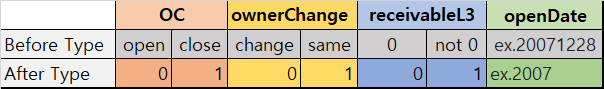


In [ ]:
df3 = df2

In [ ]:
# 변수타입 변경
############ 'OC' ############ 
df3.loc[df3["OC"]== " close", "OC"] = 1
df3.loc[df3["OC"]=="open", "OC"] = 0
df3['OC'] = df3['OC'].astype(int)

############  'ownerChange' ############ 
df3.loc[df3["ownerChange"]== "same", "ownerChange"] = 1
df3.loc[df3["ownerChange"]=="change", "ownerChange"] = 0
df3['ownerChange'] = df3['ownerChange'].astype(int)

############  'receivableL3' ############ 
df3.loc[df2['receivableL3'] != 0,'receivableL3'] = 1
df3.loc[df2['receivableL3'] == 0, 'receivableL3'] = 0
df3['receivableL3'] = df3['receivableL3'].astype(int)

############ 'openDate' ############ 
df3['openDate']=df3['openDate'].astype('string').str[0:4].astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [ ]:
df3['OC'].value_counts()

0    385
1     33
Name: OC, dtype: int64

In [ ]:
df3['ownerChange'].value_counts()

1    365
0     53
Name: ownerChange, dtype: int64

In [ ]:
df3['receivableL3'].value_counts()

0    415
1      3
Name: receivableL3, dtype: int64

In [ ]:
df3['openDate'].value_counts()

2008    39
2007    30
2014    25
2009    24
2006    23
2012    22
2013    21
2011    20
2010    19
2005    19
1988    15
1999    15
2016    13
2015    12
2004    12
2003    11
2001    11
2002     9
2000     9
2017     8
1982     7
1983     7
1998     7
1996     7
1997     6
1994     5
1993     4
1987     3
1992     2
1989     2
1995     2
1985     2
1981     2
1986     1
1984     1
1980     1
1978     1
1976     1
Name: openDate, dtype: int64

## 3.4 이상치 제거

In [ ]:
# 종속변수 'OC'와 상관관계가 가장 큰 독립변수 'profit3' 이상치 제거
# 정규분포상 평균을 기준으로 표준편차 +-3 이상 떨어진 값 제거
df4_first = df3.copy()
profit3_mean = df4_first['profit3'].mean()
profit3_std = df4_first['profit3'].std()

indexNames = df4_first[df4_first['profit3'] < profit3_mean - 3*profit3_std].index
df4_first.drop(indexNames , inplace=True)
indexNames = df4_first[df4_first['profit3'] > profit3_mean + 3*profit3_std].index
df4_first.drop(indexNames , inplace=True)

In [ ]:
# 이상치 제거 전 'OC' 개수
df3.value_counts('OC')

OC
0    385
1     33
dtype: int64

In [ ]:
# 이상치 제거 후 'OC' 개수
# Open 데이터 5개 삭제, Close 데이터 2개 삭제 -> 총 7개 행 삭제
df4_first.value_counts('OC')

OC
0    380
1     31
dtype: int64

Text(0.5, 1.0, 'after profit3 vs OC')

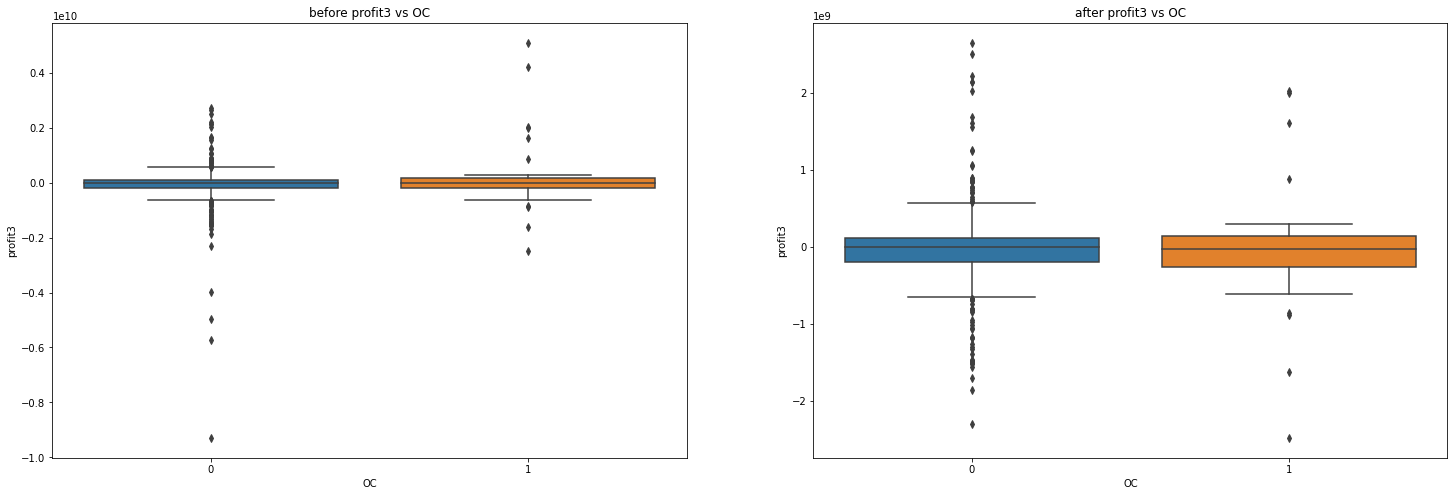

In [ ]:
#profit3 이상치 제거 전 vs 후 Boxplot
f, axes = plt.subplots(ncols=2, figsize=(25,8))

sns.boxplot(x='OC', y='profit3', data=df3, ax=axes[0])
axes[0].set_title('before profit3 vs OC')

sns.boxplot(x='OC', y='profit3', data=df4_first, ax=axes[1])
axes[1].set_title('after profit3 vs OC')

## 3.5 스케일링

###-dummy 변수 생성
- sido와 instkind를 dummy 변수로 생성

In [ ]:
# 'sido'와 'instkind'의 value 확인
df4_first['sido'].value_counts() 

gyeonggi     66
gyeongbuk    56
gyeongnam    45
busan        41
jeonbuk      30
jeonnam      29
choongnam    29
seoul        26
choongbuk    20
daegu        17
daejeon      13
ulsan        12
incheon      12
gangwon       9
gwangju       2
jeju          2
sejong        2
Name: sido, dtype: int64

In [ ]:
df4_first['instkind'].value_counts()

nursing_hospital        200
hospital                121
general_hospital         50
clinic                   21
traditional_hospital      9
traditional_clinic        6
nursing_house             3
dental_clinic             1
Name: instkind, dtype: int64

In [ ]:
# sido : level 17개 -> dummy변수 생성 
# instkind  : level 8개 -> dummy변수 생성
df5_first = pd.get_dummies(df4_first)

In [ ]:
# 열 개수 : dummy변수로 인해 55개로 증가
df5_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 427
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OC                             411 non-null    int64  
 1   ownerChange                    411 non-null    int64  
 2   bedCount                       411 non-null    float64
 3   openDate                       411 non-null    int64  
 4   sgg                            411 non-null    int64  
 5   revenue3                       411 non-null    float64
 6   salescost3                     411 non-null    float64
 7   sga3                           411 non-null    float64
 8   salary3                        411 non-null    float64
 9   noi3                           411 non-null    float64
 10  noe3                           411 non-null    float64
 11  interest3                      411 non-null    float64
 12  ctax3                          411 non-null    flo

###-Minmax

In [ ]:
y = df5_first['OC']
X = df5_first.drop('OC', axis=1)

In [ ]:
# MinMaxScaler 적용
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

MMS = MinMaxScaler()
MMS.fit(X)
X_mms = MMS.transform(X)
X_mms_pd = pd.DataFrame(X_mms, columns=X.columns)
X1 = X_mms_pd

In [ ]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ownerChange                    411 non-null    float64
 1   bedCount                       411 non-null    float64
 2   openDate                       411 non-null    float64
 3   sgg                            411 non-null    float64
 4   revenue3                       411 non-null    float64
 5   salescost3                     411 non-null    float64
 6   sga3                           411 non-null    float64
 7   salary3                        411 non-null    float64
 8   noi3                           411 non-null    float64
 9   noe3                           411 non-null    float64
 10  interest3                      411 non-null    float64
 11  ctax3                          411 non-null    float64
 12  profit3                        411 non-null    flo

## 3.6 모델링

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve

# 성능척도 함수
def get_clf_eval(y_test, pred):
  acc=accuracy_score(y_test, pred)
  pre=precision_score(y_test, pred)
  re=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)
  auc=roc_auc_score(y_test, pred)
  return acc, pre, re, f1, auc

# 미리 학습한 후, 모델 성능지표를 반환하는 함수 준비
def get_result(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)

  return get_clf_eval(y_test, pred)

# 성능척도 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
  col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
  tmp = []

  for model in models:
     tmp.append(get_result(model, X_train, y_train, X_test, y_test))
  return pd.DataFrame(tmp, columns=col_names, index=model_names)

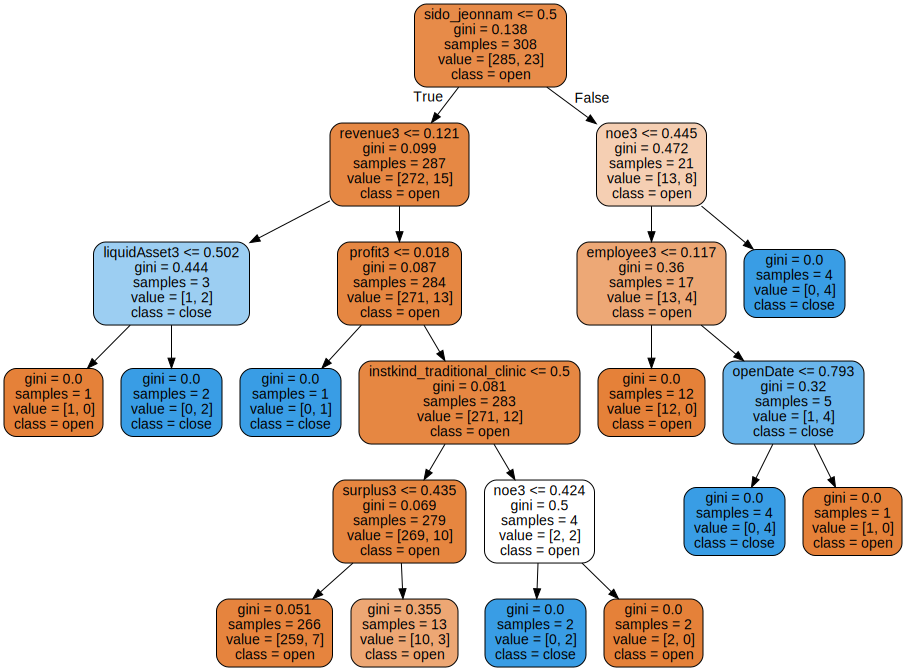

In [ ]:
# test_size = 0.25 / train_size = 0.75
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y,test_size = 0.25,random_state = 100, stratify=y)

# DecisionTree picture
dt = DecisionTreeClassifier(max_depth = 5, random_state = 13)
dt.fit(X1_train, y1_train)
pred = dt.predict(X1_test)
Source(export_graphviz(dt, feature_names=X1.columns, class_names=['open', 'close'], rounded=True, filled=True))

###-오버샘플링
 - 종속변수인 'OC' 데이터의 close 데이터가 상당히 부족하여 오버샘플링 실시

In [ ]:
# train 데이터 오버샘플링
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X1_train_over,y1_train_over = smote.fit_sample(X1_train,y1_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X1_train.shape, y1_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X1_train_over.shape, y1_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y1_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (308, 54) (308,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (570, 54) (570,)
SMOTE 적용 후 레이블 값 분포: 
 1    285
0    285
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#xgboost 사용을 위한 X's train, test numpy 변경
import numpy as np
X1_train_over = np.array(X1_train_over)
X1_test = np.array(X1_test)

###-하이퍼파라미터 튜닝
 - 그리드서치를 통한 모델의 최적 파라미터 찾기

In [ ]:
################# KNN #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

knn = KNN()
knn_parameters = {'n_neighbors':[3,5,7], 'metric':['eucldiean', 'manhattan', 'chebyshev','minkowski','wminkowski', 'seuclidean','mahalanobis']}
knn_grid = GridSearchCV(knn, param_grid=knn_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
knn_grid.fit(X1_train_over, y1_train_over)

# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df_knn = pd.DataFrame(knn_grid.cv_results_)
scores_df_knn[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'eucldiean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'eucldiean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Value

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'metric': 'eucldiean', 'n_neighbors': 3}",NaN,15,NaN,NaN,NaN
1,"{'metric': 'eucldiean', 'n_neighbors': 5}",NaN,19,NaN,NaN,NaN
2,"{'metric': 'eucldiean', 'n_neighbors': 7}",NaN,18,NaN,NaN,NaN
3,"{'metric': 'manhattan', 'n_neighbors': 3}",1.000000,1,1.000000,1.000000,1.000000
4,"{'metric': 'manhattan', 'n_neighbors': 5}",0.989474,3,0.978947,1.000000,0.989474
5,"{'metric': 'manhattan', 'n_neighbors': 7}",0.968421,7,0.936842,1.000000,0.968421
6,"{'metric': 'chebyshev', 'n_neighbors': 3}",0.975439,5,0.968421,0.968421,0.989474
7,"{'metric': 'chebyshev', 'n_neighbors': 5}",0.964912,8,0.957895,0.968421,0.968421
8,"{'metric': 'chebyshev', 'n_neighbors': 7}",0.964912,8,0.947368,0.978947,0.968421
9,"{'metric': 'minkowski', 'n_neighbors': 3}",0.996491,2,1.000000,1.000000,0.989474


In [ ]:
################# LogisticRegression #################
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold

lr_clf = LogisticRegression(random_state=10)
params = {
    'C' : np.arange(0, 1, 0.1)
}
skfold = StratifiedKFold(n_splits = 10)
grid_cv = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=skfold, verbose=1)
grid_cv.fit(X1_train_over, y1_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
model = grid_cv.best_estimator_
score = model.score(X1_test, y1_test)
print('테스트세트에서의 정확도 수치: {:.4f}'.format(score))
print("테스트 세트 AUC: {:.4f}".format(roc_auc_score(y1_test, grid_cv.decision_function(X1_test))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:935: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1. / C, sample_weight),
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:124: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + .5 * alpha * np.dot(w, w)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:129: RuntimeWarning: invalid value encountered in multiply
  grad[:n_features] = safe_sparse_dot(X.T, z0) + alpha * w
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/usr/local/l

Fitting 10 folds for each of 10 candidates, totalling 100 fits
GridSearchCV 최고 평균 정확도 수치: 0.8404
GridSearchCV 최적 하이퍼파라미터:  {'C': 0.9}
테스트세트에서의 정확도 수치: 0.7864
테스트 세트 AUC: 0.5750


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


In [ ]:
################# DecisionTreeClassifier #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
dt_parameters = {'max_depth':[2,3,4,5], 'min_samples_split':[2,3]}
dt_grid = GridSearchCV(dt, param_grid=dt_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
dt_grid.fit(X1_train_over, y1_train_over)

# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df_s = pd.DataFrame(dt_grid.cv_results_)
scores_df_s[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 2, 'min_samples_split': 2}",0.807018,4,0.789474,0.821053,0.810526
1,"{'max_depth': 2, 'min_samples_split': 3}",0.807018,4,0.789474,0.821053,0.810526
2,"{'max_depth': 3, 'min_samples_split': 2}",0.750877,7,0.715789,0.736842,0.800000
3,"{'max_depth': 3, 'min_samples_split': 3}",0.750877,7,0.715789,0.736842,0.800000
4,"{'max_depth': 4, 'min_samples_split': 2}",0.803509,6,0.736842,0.873684,0.800000
5,"{'max_depth': 4, 'min_samples_split': 3}",0.817544,3,0.757895,0.873684,0.821053
6,"{'max_depth': 5, 'min_samples_split': 2}",0.863158,1,0.778947,0.894737,0.915789
7,"{'max_depth': 5, 'min_samples_split': 3}",0.856140,2,0.757895,0.894737,0.915789


In [ ]:
################# svm #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
import sklearn.svm as svm

lr_clf = svm.SVC()
params = {
    'C' : range(1,100,10)
}
skfold = StratifiedKFold(n_splits = 10)
grid_cv = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=skfold, verbose=1)
grid_cv.fit(X1_train_over, y1_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
model = grid_cv.best_estimator_
score = model.score(X1_test, y1_test)
print('테스트세트에서의 정확도 수치: {:.4f}'.format(score))
print("테스트 세트 AUC: {:.4f}".format(roc_auc_score(y1_test, grid_cv.decision_function(X1_test))))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.9509
GridSearchCV 최적 하이퍼파라미터:  {'C': 91}
테스트세트에서의 정확도 수치: 0.8835
테스트 세트 AUC: 0.5566


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


In [ ]:
# Xgboost 설치
!pip install --upgrade xgboost==0.4a30
import xgboost 

     |████████████████████████████████| 757kB 5.8MB/s 
  Created wheel for xgboost: filename=xgboost-0.4a30-cp36-none-any.whl size=789341 sha256=f7cbfb0d1106f13538a755417428b25c07b20b67d595286873e69855a3175be8
  Stored in directory: /root/.cache/pip/wheels/9d/5f/5c/98c042c89500060dc779a58c6510bf162c061ea6bcfcc7188f
Successfully built xgboost
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
################# xgb #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb_parameters = {'n_estimators':[100,200,400,600], 'learning_rate':[0.01,0.05,0.1,0.15,0.2], 'max_depth':[4,6,8]}
xgb_grid = GridSearchCV(xgb, param_grid=xgb_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
xgb_grid.fit(X1_train_over, y1_train_over)
print('최적 하이퍼 파라미터: ', xgb_grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(xgb_grid.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 600}
최고 예측 정확도: 0.9860


In [ ]:
################# random forest #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = { 'n_estimators' : [10, 100],
           'max_depth' : [4, 6, 8],
           'min_samples_leaf' : [10, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X1_train_over, y1_train_over)
print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9421


###-모델 적용
- KNN,  Decision Tree, LogisticRegression, SVM, Xgboost ,Random Forest

In [ ]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier as KNN
model_KNN = KNN(n_neighbors=3, metric="manhattan") 
model_KNN.fit(X1_train_over, y1_train_over)
knn_pred = model_KNN.predict(X1_test)

# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=5, min_samples_split=3)
dt_clf.fit(X1_train_over, y1_train_over)
dt_pred = dt_clf.predict(X1_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=13, solver='liblinear', C=0.9)
lr_clf.fit(X1_train_over, y1_train_over)
lr_pred = lr_clf.predict(X1_test)

# SVM
import sklearn.svm as svm
import sklearn.metrics as mt
l_svm_clf = svm.SVC(C=91, kernel = 'linear')
l_svm_clf.fit(X1_train_over, y1_train_over)
l_svm_pred = l_svm_clf.predict(X1_test)

# Xgboost
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=600, learning_rate=0.05, max_depth = 8)
xgb_clf.fit(X1_train_over, y1_train_over)
xgb_pred = xgb_clf.predict(X1_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 8,
                                min_samples_leaf = 10,
                                min_samples_split = 8,
                                random_state = 100,
                                n_jobs = -1)
rf_clf1.fit(X1_train_over, y1_train_over)
rf_clf1_pred = rf_clf1.predict(X1_test)


models_1 = [model_KNN, dt_clf, lr_clf, l_svm_clf, xgb_clf, rf_clf1]
model_names_1 = ['KNN','DecisionTree', 'LogisticReg', 'SVM', 'Xgboost', 'Random Forest']

results_1 = get_result_pd(models_1, model_names_1, X1_train_over, y1_train_over, X1_test, y1_test)
results_1

,accuracy,precision,recall,f1,roc_auc
KNN,0.834951,0.000000,0.000,0.000000,0.452632
DecisionTree,0.805825,0.000000,0.000,0.000000,0.436842
LogisticReg,0.786408,0.111111,0.250,0.153846,0.540789
SVM,0.786408,0.181818,0.500,0.266667,0.655263
Xgboost,0.854369,0.111111,0.125,0.117647,0.520395
Random Forest,0.883495,0.166667,0.125,0.142857,0.536184


- 1차 전처리 이후 모델링 결과 SVM의 auc-score가 0.655로 가장 높게 나왔다.

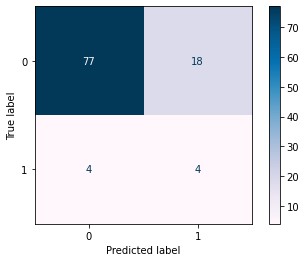

In [ ]:
# roc_auc가 가장 높은 'SVM'의 confusion matrix
from sklearn.metrics import *
plot_confusion_matrix(l_svm_clf, X1_test, y1_test, cmap='PuBu')

In [ ]:
print(classification_report(y1_test, l_svm_pred, target_names =['Open', 'Close']))

              precision    recall  f1-score   support

        Open       0.95      0.81      0.87        95
       Close       0.18      0.50      0.27         8

    accuracy                           0.79       103
   macro avg       0.57      0.66      0.57       103
weighted avg       0.89      0.79      0.83       103



#데이터전처리[2차+모델링]

##3.7 이상치 대치
- 모델 성능의 값이 좋지 않아, 3.4 이상치 제거 대신 대치로 변경


In [ ]:
# 'OC'를 기준으로 open 데이터와 close 데이터를 분리하여 open 데이터만을 가지고 이상치 대체
df4_second = df3.copy()

In [ ]:
# 'OC'의 open 데이터
df4_open = df4_second[df4_second['OC'] == 0]
df4_open.head()

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
0,0,choongnam,nursing_hospital,1,175.0,2007,73,-8.031824e+07,0.0,-9.628707e+07,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,1.811014e+08,-53646830.0,1428837.0,-3.352830e+07,-2.557930e+07,-2449000.0,0,-7.616775e+07,-2.155316e+07,0.000000e+00,-5.461460e+07,-3.900000e+07,225169678.0,2.251697e+08,-2.0
2,0,gyeonggi,nursing_hospital,1,468.0,2016,89,1.004522e+09,515483669.0,4.472197e+08,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,2.536822e+08,8095950.0,18759968.0,1.204810e+08,1.204810e+08,0.0,0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,300508824.0,0.000000e+00,233.0
3,0,incheon,general_hospital,1,353.0,2000,141,5.649006e+09,0.0,5.753205e+09,2.074703e+09,29415255.0,-94104842.0,-80540715.0,-45121940.0,64442822.0,1.915823e+09,1.644210e+09,0.0,271612480.0,3.595795e+09,3.465022e+09,29302018.0,0,4.608787e+09,1.097328e+10,1.066577e+10,-6.364497e+09,-7.846960e+09,902830288.0,9.028303e+08,0.0
4,0,gyeongnam,general_hospital,1,196.0,2005,32,9.607370e+08,0.0,5.302526e+08,1.000740e+09,-485395869.0,-103018625.0,-42602315.0,0.0,48107111.0,1.410308e+09,1.409248e+09,734093256.0,1059446.0,-2.864045e+09,-2.323317e+09,-567000700.0,0,-1.534487e+09,-1.163398e+09,3.366231e+08,-3.710896e+08,-6.080275e+08,80749696.0,0.000000e+00,9.0
5,0,gyeongnam,general_hospital,1,243.0,2002,155,-7.539098e+08,-616142017.0,-3.683077e+08,2.674107e+08,-60266829.0,291186440.0,-79048185.0,0.0,-120913329.0,7.656857e+08,7.558229e+08,465865678.0,9862851.0,-3.477443e+09,-3.361751e+09,-54587822.0,0,0.000000e+00,-3.361751e+09,9.339000e+07,-2.000000e+07,0.000000e+00,0.0,-2.214085e+09,7.0


In [ ]:
# 'OC'의 close 데이터
df4_close = df4_second[df4_second['OC'] == 1]
df4_close.head()

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
35,1,gyeonggi,nursing_hospital,0,132.0,2013,168,5.886334e+08,37346774.0,2.631901e+08,20162917.0,3.797698e+07,2.814229e+08,170968801.0,0.0,4.465068e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.0
71,1,jeonbuk,traditional_hospital,1,151.0,1999,26,8.137167e+08,-698553.0,5.469987e+08,488767017.0,-1.613954e+06,6.368427e+07,22281582.0,8870770.0,1.932476e+08,2.762937e+08,2.774796e+08,0.000000e+00,-1185900.0,1.022246e+08,-2.846485e+07,116672740.0,0,1.455889e+08,1.611090e+08,1.470493e+08,-1.552017e+07,0.000000e+00,2.329294e+08,0.000000e+00,11.0
93,1,gyeongbuk,hospital,1,203.0,2007,114,3.496934e+08,0.0,2.279551e+08,-101783870.0,-1.654775e+07,-4.025030e+05,-152491.0,704480.0,1.048886e+08,1.669880e+09,1.573351e+09,2.538957e+08,96528420.0,1.488174e+08,1.488174e+08,0.0,0,1.724047e+09,1.724047e+09,1.750000e+09,0.000000e+00,0.000000e+00,9.465001e+07,0.000000e+00,10.0
111,1,jeonbuk,nursing_hospital,1,326.0,2005,136,2.179021e+09,312206615.0,1.507567e+09,907395730.0,3.343641e+07,2.082812e+08,18920952.0,0.0,1.844022e+08,3.535250e+09,3.432644e+09,3.132667e+09,102605576.0,1.668178e+10,1.665105e+10,0.0,0,1.249684e+10,5.800804e+09,1.309874e+09,6.696035e+09,4.089147e+09,7.720191e+09,7.720191e+09,2.0
141,1,busan,hospital,1,151.0,1999,63,1.867326e+07,0.0,-5.080033e+08,138573227.0,1.369737e+09,-2.322157e+09,-170716293.0,0.0,4.218571e+09,-4.877154e+09,-4.876806e+09,7.871124e+08,-348360.0,2.029254e+09,2.003438e+09,35000000.0,0,-8.297345e+09,-7.284222e+09,-5.700000e+09,-1.013123e+09,-1.001123e+09,5.449445e+09,0.000000e+00,0.0


In [ ]:
df4_open_copy=df4_open.copy()

In [ ]:
df4_open.dtypes

OC                      int64
sido                   object
instkind               object
ownerChange             int64
bedCount              float64
openDate                int64
sgg                     int64
revenue3              float64
salescost3            float64
sga3                  float64
salary3               float64
noi3                  float64
noe3                  float64
interest3             float64
ctax3                 float64
profit3               float64
liquidAsset3          float64
quickAsset3           float64
receivableS3          float64
inventoryAsset3       float64
nonCAsset3            float64
tanAsset3             float64
OnonCAsset3           float64
receivableL3            int64
debt3                 float64
liquidLiabilities3    float64
shortLoan3            float64
NCLiabilities3        float64
longLoan3             float64
netAsset3             float64
surplus3              float64
employee3             float64
dtype: object

In [ ]:
# open 데이터의 column 개수
list_col = list(df4_open.columns)
len(list_col)

32

In [ ]:
# 수치형 데이터를 제외한 변수 제거
del list_col[list_col.index('OC')]
del list_col[list_col.index('sido')]
del list_col[list_col.index('instkind')]
del list_col[list_col.index('ownerChange')]
del list_col[list_col.index('sgg')]
del list_col[list_col.index('receivableL3')]

In [ ]:
len(list_col)

26

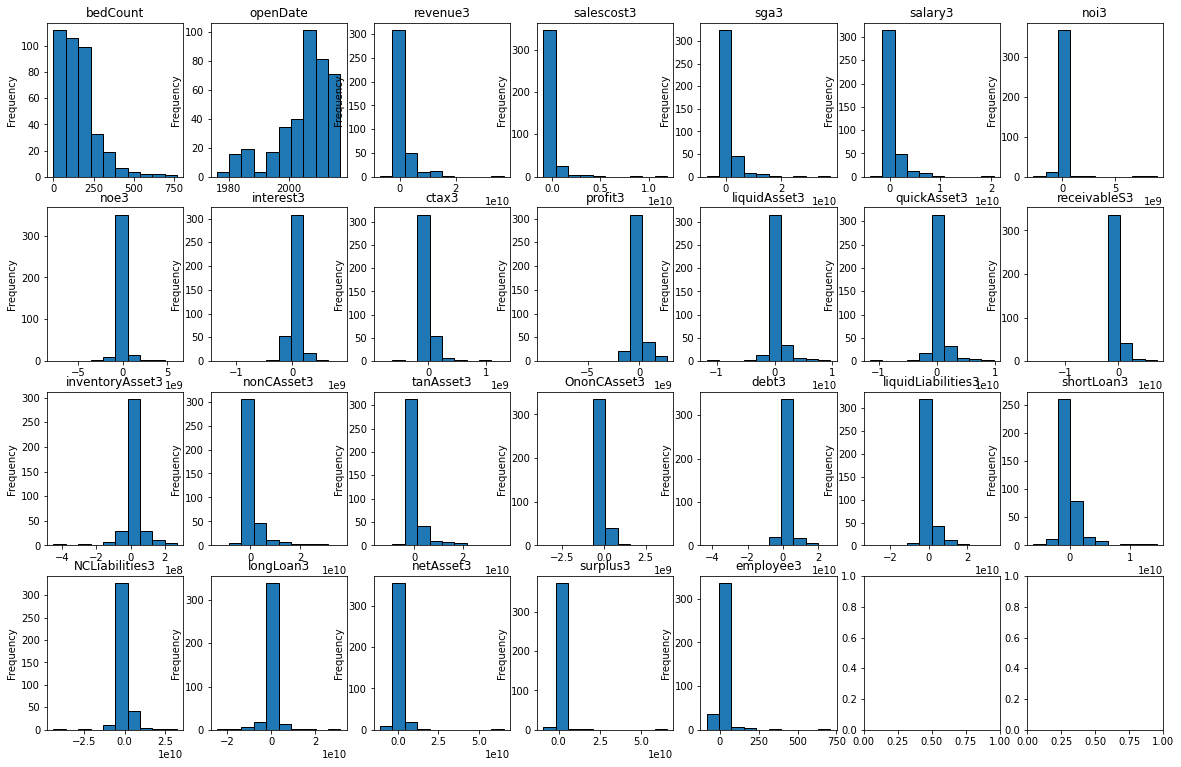

In [ ]:
# 히스토그램을 이용하여 open의 수치형 데이터 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,7)

fig.set_size_inches((20,13))
for var, subplot in zip(list_col,ax.flatten()):

  df4_open[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

In [ ]:
# open 데이터의 outlier 대치(iqr 사용)
# 1사분위와 3사분위 밖에 있는 점은 1사분위와 3사분위에 가까운 점으로 대치
def outlier_change(df, li_col):
  for i in range(0, len(li_col)):

    a = df[li_col[i]]
    weight = 1.5
    quantile_25 = np.percentile(a.values, 25)
    quantile_75 = np.percentile(a.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = list(a[(a<lowest_val)|(a>highest_val)].index)
    lowest_index = list(a[(a<lowest_val)].index)
    highest_index= list(a[(a>highest_val)].index)

    value = []

    if(len(outlier_index) != 0) : # 만약, 아웃라이어 값이 존재한다면
      for index in range(0, len(lowest_index)):
         df.loc[[lowest_index[index]],[li_col[i]]] = lowest_val
      
      for  index in range(0, len( highest_index)):
         df.loc[[ highest_index[index]],[li_col[i]]] =  highest_val

In [ ]:
outlier_change(df4_open, list_col)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

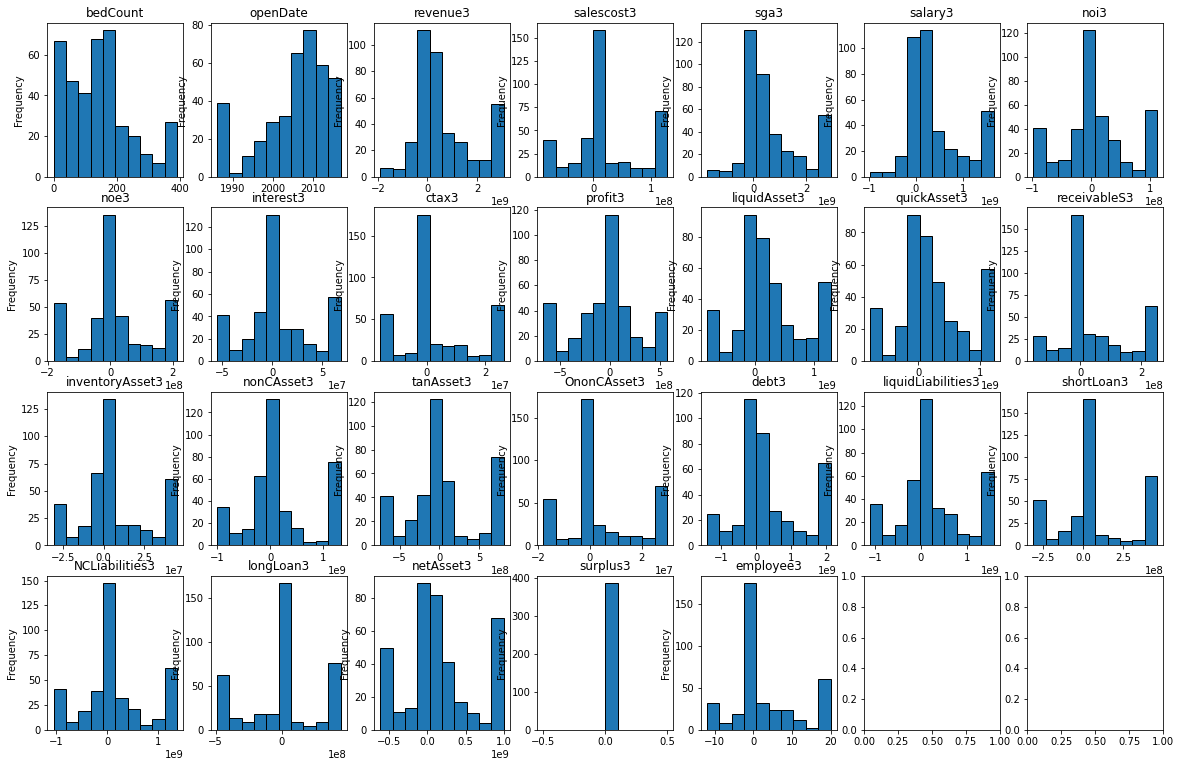

In [ ]:
# outlier 대치 후 open의 수치형 데이터 분포 확인
fig, ax = plt.subplots(4,7)

fig.set_size_inches((20,13))
for var, subplot in zip(list_col,ax.flatten()):

  df4_open[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

In [ ]:
# open 데이터의 제거했던 변수 추가
add_col = df4_open_copy['OC'].values
add_col2 = df4_open_copy['sido'].values
add_col3 = df4_open_copy['instkind'].values
add_col4 = df4_open_copy['ownerChange'].values
add_col5 = df4_open_copy['sgg'].values
add_col6 = df4_open_copy['receivableL3'].values

In [ ]:
df4_open['OC'] = add_col
df4_open['sido'] = add_col2
df4_open['instkind'] = add_col3
df4_open['ownerChange'] = add_col4
df4_open['sgg'] = add_col5
df4_open['receivableL3'] = add_col6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
list(df4_open.columns)

['OC',
 'sido',
 'instkind',
 'ownerChange',
 'bedCount',
 'openDate',
 'sgg',
 'revenue3',
 'salescost3',
 'sga3',
 'salary3',
 'noi3',
 'noe3',
 'interest3',
 'ctax3',
 'profit3',
 'liquidAsset3',
 'quickAsset3',
 'receivableS3',
 'inventoryAsset3',
 'nonCAsset3',
 'tanAsset3',
 'OnonCAsset3',
 'receivableL3',
 'debt3',
 'liquidLiabilities3',
 'shortLoan3',
 'NCLiabilities3',
 'longLoan3',
 'netAsset3',
 'surplus3',
 'employee3']

In [ ]:
# outlier 제거한 open 데이터와 기존 close 데이터 병합
frames = [df4_open, df4_close]
df4_second = pd.concat(frames)
df4_second

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
0,0,choongnam,nursing_hospital,1,175.0,2007.0,73,-8.031824e+07,0.0,-9.628707e+07,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,1.811014e+08,-53646830.0,1428837.0,-3.352830e+07,-25579299.0,-2449000.0,0,-7.616775e+07,-2.155316e+07,0.0,-5.461460e+07,-3.900000e+07,2.251697e+08,0.0,-2.0
2,0,gyeonggi,nursing_hospital,1,392.0,2016.0,89,1.004522e+09,127739932.0,4.472197e+08,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,2.536822e+08,8095950.0,18759968.0,1.204810e+08,120481028.0,0.0,0,9.241434e+07,9.241434e+07,0.0,0.000000e+00,0.000000e+00,3.005088e+08,0.0,20.0
3,0,incheon,general_hospital,1,353.0,2000.0,141,3.082989e+09,0.0,2.906180e+09,1.659052e+09,29415255.0,-94104842.0,-55352210.5,-15883957.5,64442822.0,1.275637e+09,1.216930e+09,0.0,45636891.5,1.331523e+09,814847980.5,29302018.0,0,2.129946e+09,1.576245e+09,460148219.0,-1.051356e+09,-4.905037e+08,9.028303e+08,0.0,0.0
4,0,gyeongnam,general_hospital,1,196.0,2005.0,32,9.607370e+08,0.0,5.302526e+08,1.000740e+09,-98141328.0,-103018625.0,-42602315.0,0.0,48107111.0,1.275637e+09,1.216930e+09,252709845.0,1059446.0,-1.011821e+09,-745053503.5,-17865000.0,0,-1.409470e+09,-1.101214e+09,336623138.0,-3.710896e+08,-4.905037e+08,8.074970e+07,0.0,9.0
5,0,gyeongnam,general_hospital,1,243.0,2002.0,155,-7.539098e+08,-86185580.0,-3.683077e+08,2.674107e+08,-60266829.0,213799538.5,-55352210.5,0.0,-120913329.0,7.656857e+08,7.558229e+08,252709845.0,9862851.0,-1.011821e+09,-745053503.5,-17865000.0,0,0.000000e+00,-1.101214e+09,93390000.0,-2.000000e+07,0.000000e+00,0.000000e+00,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,busan,nursing_hospital,1,151.0,2010.0,66,-2.244973e+09,-650410974.0,-1.613140e+09,-9.824096e+08,-2467843.0,78026204.0,-54489520.0,-1340130.0,-60576116.0,-6.259562e+07,-5.252514e+07,-8798366.0,-1637000.0,-1.496617e+08,-137705707.0,-11956000.0,0,1.586852e+07,1.586852e+07,0.0,0.000000e+00,0.000000e+00,-2.281258e+08,0.0,0.0
423,1,jeonnam,traditional_clinic,1,0.0,2001.0,33,-6.478885e+07,-742841.0,4.375277e+08,9.335632e+08,-59818683.0,-269660838.0,-153130496.0,-137857554.0,-153873997.0,1.204736e+09,1.165499e+09,644261571.0,39237644.0,6.826569e+08,926325081.0,2000000.0,0,1.951897e+08,-2.207433e+07,0.0,2.172640e+08,0.000000e+00,1.692204e+09,0.0,10.0
424,1,gyeonggi,traditional_hospital,1,151.0,2001.0,74,-7.759709e+08,0.0,-6.460058e+08,-4.263722e+08,-9779723.0,-53108189.0,-35378688.0,528685902.0,-615322508.0,-8.826843e+08,-8.826843e+08,-133178510.0,0.0,6.249577e+08,518737744.0,106220000.0,0,-1.237918e+09,5.165253e+08,0.0,-1.754443e+09,-1.740000e+09,9.801914e+08,980191435.0,-5.0
425,1,gyeonggi,hospital,1,150.0,2001.0,116,1.170330e+09,96884054.0,8.814367e+08,6.235152e+08,-98769400.0,50608589.0,157710291.0,517770.0,42113908.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.0


## 3.8 스케일링




###-dummy 변수 생성
- sido와 instkind를 dummy 변수로 생성

In [ ]:
# sido : level 17개 -> dummy변수 생성 
# instkind  : level 8개 -> dummy변수 생성
df5_second = pd.get_dummies(df4_second)

In [ ]:
# 열 개수 : dummy변수로 인해 55개로 증가
df5_second.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 427
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OC                             418 non-null    int64  
 1   ownerChange                    418 non-null    int64  
 2   bedCount                       418 non-null    float64
 3   openDate                       418 non-null    float64
 4   sgg                            418 non-null    int64  
 5   revenue3                       418 non-null    float64
 6   salescost3                     418 non-null    float64
 7   sga3                           418 non-null    float64
 8   salary3                        418 non-null    float64
 9   noi3                           418 non-null    float64
 10  noe3                           418 non-null    float64
 11  interest3                      418 non-null    float64
 12  ctax3                          418 non-null    flo

###-Minmax


In [ ]:
y = df5_second['OC']
X = df5_second.drop('OC', axis=1)

In [ ]:
# MinMaxScaler 적용
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

MMS = MinMaxScaler()
MMS.fit(X)
X_mms = MMS.transform(X)
X_mms_pd = pd.DataFrame(X_mms, columns=X.columns)
X2 = X_mms_pd

##3.9 모델링

In [ ]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ownerChange                    418 non-null    float64
 1   bedCount                       418 non-null    float64
 2   openDate                       418 non-null    float64
 3   sgg                            418 non-null    float64
 4   revenue3                       418 non-null    float64
 5   salescost3                     418 non-null    float64
 6   sga3                           418 non-null    float64
 7   salary3                        418 non-null    float64
 8   noi3                           418 non-null    float64
 9   noe3                           418 non-null    float64
 10  interest3                      418 non-null    float64
 11  ctax3                          418 non-null    float64
 12  profit3                        418 non-null    flo

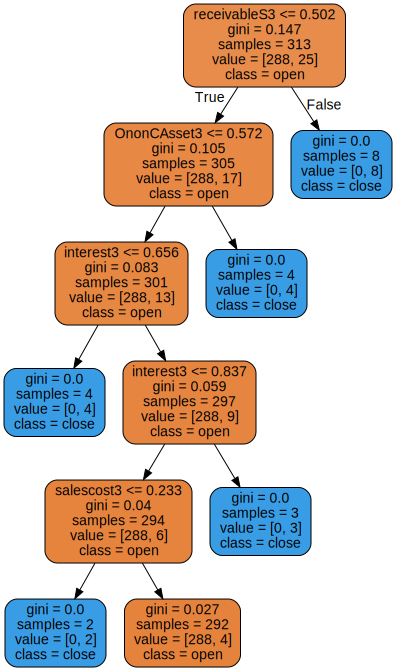

In [ ]:
# test_size = 0.25 / train_size = 0.75
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y,test_size = 0.25,random_state = 100, stratify=y)

# DecisionTree picture
dt = DecisionTreeClassifier(max_depth = 5, random_state = 13)
dt.fit(X2_train, y2_train)
pred = dt.predict(X2_test)
Source(export_graphviz(dt, feature_names=X2.columns, class_names=['open', 'close'], rounded=True, filled=True))

###-오버샘플링
 - 종속변수인 'OC' 데이터의 close 데이터가 상당히 부족하여 오버샘플링 실시

In [ ]:
# train 데이터 오버샘플링
smote = SMOTE(random_state=0)
X2_train_over,y2_train_over = smote.fit_sample(X2_train,y2_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X2_train.shape, y2_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X2_train_over.shape, y2_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y2_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (313, 54) (313,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (576, 54) (576,)
SMOTE 적용 후 레이블 값 분포: 
 1    288
0    288
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#xgboost 사용을 위한 X's train, test numpy 변경
import numpy as np
X2_train_over = np.array(X2_train_over)
X2_test = np.array(X2_test)

###-하이퍼파라미터 튜닝
 - 그리드서치를 통한 모델의 최적 파라미터 찾기

In [ ]:
################# KNN #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

knn = KNN()
knn_parameters = {'n_neighbors':[3,5,7], 'metric':['eucldiean', 'manhattan', 'chebyshev','minkowski','wminkowski', 'seuclidean','mahalanobis']}
knn_grid = GridSearchCV(knn, param_grid=knn_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
knn_grid.fit(X2_train_over, y2_train_over)
# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df_knn = pd.DataFrame(knn_grid.cv_results_)
scores_df_knn[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'eucldiean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'eucldiean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Value

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'metric': 'eucldiean', 'n_neighbors': 3}",NaN,15,NaN,NaN,NaN
1,"{'metric': 'eucldiean', 'n_neighbors': 5}",NaN,19,NaN,NaN,NaN
2,"{'metric': 'eucldiean', 'n_neighbors': 7}",NaN,18,NaN,NaN,NaN
3,"{'metric': 'manhattan', 'n_neighbors': 3}",0.993056,2,1.000000,0.989583,0.989583
4,"{'metric': 'manhattan', 'n_neighbors': 5}",0.993056,2,1.000000,0.989583,0.989583
5,"{'metric': 'manhattan', 'n_neighbors': 7}",0.989583,4,1.000000,0.989583,0.979167
6,"{'metric': 'chebyshev', 'n_neighbors': 3}",0.982639,7,0.989583,0.979167,0.979167
7,"{'metric': 'chebyshev', 'n_neighbors': 5}",0.975694,9,0.989583,0.958333,0.979167
8,"{'metric': 'chebyshev', 'n_neighbors': 7}",0.979167,8,0.989583,0.968750,0.979167
9,"{'metric': 'minkowski', 'n_neighbors': 3}",0.996528,1,1.000000,0.989583,1.000000


In [ ]:
################# LogisticRegression #################
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold

lr_clf = LogisticRegression(random_state=10)
params = {
    'C' : np.arange(0, 1, 0.1)
}
skfold = StratifiedKFold(n_splits = 10)
grid_cv = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=skfold, verbose=1)
grid_cv.fit(X2_train_over, y2_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
model = grid_cv.best_estimator_
score = model.score(X2_test, y2_test)
print('테스트세트에서의 정확도 수치: {:.4f}'.format(score))
print("테스트 세트 AUC: {:.4f}".format(roc_auc_score(y2_test, grid_cv.decision_function(X2_test))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:935: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1. / C, sample_weight),
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:124: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + .5 * alpha * np.dot(w, w)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:129: RuntimeWarning: invalid value encountered in multiply
  grad[:n_features] = safe_sparse_dot(X.T, z0) + alpha * w
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/usr/local/l

Fitting 10 folds for each of 10 candidates, totalling 100 fits
GridSearchCV 최고 평균 정확도 수치: 0.8489
GridSearchCV 최적 하이퍼파라미터:  {'C': 0.9}
테스트세트에서의 정확도 수치: 0.7905
테스트 세트 AUC: 0.6894


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [ ]:
################# DecisionTreeClassifier #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
dt_parameters = {'max_depth':[2,3,4,5], 'min_samples_split':[2,3]}
dt_grid = GridSearchCV(dt, param_grid=dt_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
dt_grid.fit(X2_train_over, y2_train_over)
# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df_s = pd.DataFrame(dt_grid.cv_results_)
scores_df_s[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 2, 'min_samples_split': 2}",0.611111,7,0.520833,0.531250,0.781250
1,"{'max_depth': 2, 'min_samples_split': 3}",0.611111,7,0.520833,0.531250,0.781250
2,"{'max_depth': 3, 'min_samples_split': 2}",0.704861,6,0.614583,0.666667,0.833333
3,"{'max_depth': 3, 'min_samples_split': 3}",0.718750,5,0.656250,0.666667,0.833333
4,"{'max_depth': 4, 'min_samples_split': 2}",0.875000,3,0.875000,0.864583,0.885417
5,"{'max_depth': 4, 'min_samples_split': 3}",0.864583,4,0.843750,0.864583,0.885417
6,"{'max_depth': 5, 'min_samples_split': 2}",0.895833,2,0.906250,0.875000,0.906250
7,"{'max_depth': 5, 'min_samples_split': 3}",0.899306,1,0.916667,0.875000,0.906250


In [ ]:
################# svc #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
import sklearn.svm as svm

lr_clf = svm.SVC()
params = {
    'C' : range(1,100,10)
}
skfold = StratifiedKFold(n_splits = 10)
grid_cv = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=skfold, verbose=1)
grid_cv.fit(X2_train_over, y2_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
model = grid_cv.best_estimator_
score = model.score(X2_test, y2_test)
print('테스트세트에서의 정확도 수치: {:.4f}'.format(score))
print("테스트 세트 AUC: {:.4f}".format(roc_auc_score(y2_test, grid_cv.decision_function(X2_test))))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.9827
GridSearchCV 최적 하이퍼파라미터:  {'C': 41}
테스트세트에서의 정확도 수치: 0.9143
테스트 세트 AUC: 0.6920


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [ ]:
################# xgb #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
xgb_parameters = {'n_estimators':[100,200,400,600], 'learning_rate':[0.01,0.05,0.1,0.15,0.2], 'max_depth':[4,6,8]}
xgb_grid = GridSearchCV(xgb, param_grid=xgb_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
xgb_grid.fit(X2_train_over, y2_train_over)
print('최적 하이퍼 파라미터: ', xgb_grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(xgb_grid.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400}
최고 예측 정확도: 0.9861


In [ ]:
################# random forest #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = { 'n_estimators' : [10, 100],
           'max_depth' : [4, 6, 8],
           'min_samples_leaf' : [10, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X2_train_over, y2_train_over)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9757


###-모델 적용
- KNN,  Decision Tree, LogisticRegression, SVM, Xgoost, Random Forest

In [ ]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier as KNN
model_KNN = KNN(n_neighbors=3, metric="minkowski") 
model_KNN.fit(X2_train_over, y2_train_over)
knn_pred = model_KNN.predict(X2_test)

# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=5, min_samples_split=2)
dt_clf.fit(X2_train_over, y2_train_over)
dt_pred = dt_clf.predict(X2_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=13, solver='liblinear', C=0.9)
lr_clf.fit(X2_train_over, y2_train_over)
lr_pred = lr_clf.predict(X2_test)

# SVM
import sklearn.svm as svm
import sklearn.metrics as mt
l_svm_clf = svm.SVC(C=41, kernel = 'linear')
l_svm_clf.fit(X2_train_over, y2_train_over)
l_svm_pred = l_svm_clf.predict(X2_test)

# Xgboost
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth = 4)
xgb_clf.fit(X2_train_over, y2_train_over)
xgb_pred = xgb_clf.predict(X2_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 8,
                                min_samples_leaf = 12,
                                min_samples_split = 8,
                                random_state = 100,
                                n_jobs = -1)
rf_clf1.fit(X2_train_over, y2_train_over)
rf_clf1_pred = rf_clf1.predict(X2_test)


models_2 = [model_KNN, dt_clf, lr_clf, l_svm_clf, xgb_clf, rf_clf1]
model_names_2 = ['KNN','DecisionTree', 'LogisticReg', 'SVM', 'Xgboost', 'Random Forest']

results_2 = get_result_pd(models_2, model_names_2, X2_train_over, y2_train_over, X2_test, y2_test)
results_2

,accuracy,precision,recall,f1,roc_auc
KNN,0.819048,0.176471,0.375,0.240000,0.615335
DecisionTree,0.914286,0.461538,0.750,0.571429,0.838918
LogisticReg,0.790476,0.150000,0.375,0.214286,0.599871
SVM,0.857143,0.266667,0.500,0.347826,0.693299
Xgboost,0.980952,1.000000,0.750,0.857143,0.875000
Random Forest,0.980952,1.000000,0.750,0.857143,0.875000


- 2차 전처리 이후 모델링 결과 Xgboost와 Random Forest auc-score가 0.875로 가장 높게 나왔다.

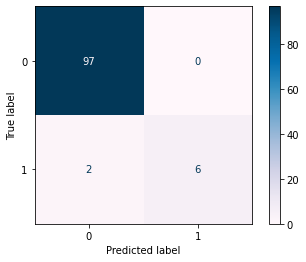

In [ ]:
# roc_auc가 가장 높은 'Xgboost'와 'Random Forest'의 confusion matrix
from sklearn.metrics import *
plot_confusion_matrix(xgb_clf, X2_test, y2_test, cmap='PuBu')

In [ ]:
print(classification_report(y2_test, xgb_pred, target_names =['Open', 'Close']))

              precision    recall  f1-score   support

        Open       0.98      1.00      0.99        97
       Close       1.00      0.75      0.86         8

    accuracy                           0.98       105
   macro avg       0.99      0.88      0.92       105
weighted avg       0.98      0.98      0.98       105



#데이터전처리[3차+모델링]

##3.10 상관관계 분석 후 변수 제거
- 독립변수간 상관관계가 높은 변수 제거

In [ ]:
re=df3.corr()

In [ ]:
# 상관계수가 0.8이상인 변수 표시
re2 = re[re>abs(0.8)]
re2

,OC,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,sga3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,quickAsset3,receivableS3,inventoryAsset3,nonCAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,netAsset3,surplus3,employee3
OC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ownerChange,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedCount,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
openDate,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sgg,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue3,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.899264,0.918199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salescost3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sga3,NaN,NaN,NaN,NaN,NaN,0.899264,NaN,1.000000,0.933204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary3,NaN,NaN,NaN,NaN,NaN,0.918199,NaN,0.933204,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
noi3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_names = list(re2)
row_names = list(re2.index)

In [ ]:
# 상관관계가 0.8이상인 피쳐들의 이름 뽑음
result = []
for i in range(0, len(column_names)):
  for j in range(0,len(row_names)):
    value = []
    if ( (re2[column_names[i]][row_names[j]] > 0.8) & (re2[column_names[i]][row_names[j]] < 1 )) :
      value.append(column_names[i])
      value.append(row_names[j])
      value.append(re2[column_names[i]][row_names[j]])
      result.append(value)
result

[['revenue3', 'sga3', 0.8992637976865964],
 ['revenue3', 'salary3', 0.9181987784918296],
 ['sga3', 'revenue3', 0.8992637976865964],
 ['sga3', 'salary3', 0.9332043622377084],
 ['salary3', 'revenue3', 0.9181987784918296],
 ['salary3', 'sga3', 0.9332043622377084],
 ['liquidAsset3', 'quickAsset3', 0.9972606001522076],
 ['quickAsset3', 'liquidAsset3', 0.9972606001522076],
 ['nonCAsset3', 'tanAsset3', 0.9794514036295525],
 ['tanAsset3', 'nonCAsset3', 0.9794514036295525],
 ['netAsset3', 'surplus3', 0.855853389523327],
 ['surplus3', 'netAsset3', 0.855853389523327]]

In [ ]:
# 상관계수가 0.8이상인 변수 둘 중 택1 하여 제거 : 'sga3','quickAsset3','nonCAsset3','netAsset3'
df6 = df3.drop(['sga3','quickAsset3','nonCAsset3','netAsset3'], axis=1)
df6

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,receivableS3,inventoryAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,surplus3,employee3
0,0,choongnam,nursing_hospital,1,175.0,2007,73,-8.031824e+07,0.000000e+00,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,-53646830.0,1428837.0,-2.557930e+07,-2449000.0,0,-7.616775e+07,-2.155316e+07,0.000000e+00,-5.461460e+07,-3.900000e+07,2.251697e+08,-2.0
2,0,gyeonggi,nursing_hospital,1,468.0,2016,89,1.004522e+09,5.154837e+08,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,8095950.0,18759968.0,1.204810e+08,0.0,0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,233.0
3,0,incheon,general_hospital,1,353.0,2000,141,5.649006e+09,0.000000e+00,2.074703e+09,29415255.0,-94104842.0,-80540715.0,-45121940.0,64442822.0,1.915823e+09,0.0,271612480.0,3.465022e+09,29302018.0,0,4.608787e+09,1.097328e+10,1.066577e+10,-6.364497e+09,-7.846960e+09,9.028303e+08,0.0
4,0,gyeongnam,general_hospital,1,196.0,2005,32,9.607370e+08,0.000000e+00,1.000740e+09,-485395869.0,-103018625.0,-42602315.0,0.0,48107111.0,1.410308e+09,734093256.0,1059446.0,-2.323317e+09,-567000700.0,0,-1.534487e+09,-1.163398e+09,3.366231e+08,-3.710896e+08,-6.080275e+08,0.000000e+00,9.0
5,0,gyeongnam,general_hospital,1,243.0,2002,155,-7.539098e+08,-6.161420e+08,2.674107e+08,-60266829.0,291186440.0,-79048185.0,0.0,-120913329.0,7.656857e+08,465865678.0,9862851.0,-3.361751e+09,-54587822.0,0,0.000000e+00,-3.361751e+09,9.339000e+07,-2.000000e+07,0.000000e+00,-2.214085e+09,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,jeonnam,traditional_clinic,1,0.0,2001,33,-6.478885e+07,-7.428410e+05,9.335632e+08,-59818683.0,-269660838.0,-153130496.0,-137857554.0,-153873997.0,1.204736e+09,644261571.0,39237644.0,9.263251e+08,2000000.0,0,1.951897e+08,-2.207433e+07,0.000000e+00,2.172640e+08,0.000000e+00,0.000000e+00,10.0
424,1,gyeonggi,traditional_hospital,1,151.0,2001,74,-7.759709e+08,0.000000e+00,-4.263722e+08,-9779723.0,-53108189.0,-35378688.0,528685902.0,-615322508.0,-8.826843e+08,-133178510.0,0.0,5.187377e+08,106220000.0,0,-1.237918e+09,5.165253e+08,0.000000e+00,-1.754443e+09,-1.740000e+09,9.801914e+08,-5.0
425,1,gyeonggi,hospital,1,150.0,2001,116,1.170330e+09,9.688405e+07,6.235152e+08,-98769400.0,50608589.0,157710291.0,517770.0,42113908.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.0
426,0,jeju,nursing_house,1,151.0,2001,76,1.342325e+09,1.412956e+09,1.102062e+08,-14697359.0,-4344458.0,-5412045.0,31802061.0,226947698.0,2.434632e+09,0.0,139103387.0,9.131159e+08,424569085.0,0,1.386918e+09,8.568958e+08,0.000000e+00,5.300218e+08,0.000000e+00,0.000000e+00,20.0


##3.11 이상치 대치

In [ ]:
## 'OC'를 기준으로 open 데이터와 close 데이터를 분리하여 open 데이터만을 가지고 이상치 대체
df4_third = df6.copy()

In [ ]:
# 'OC'의 open 데이터
df4_open = df4_third[df4_third['OC'] == 0]
df4_open.head()

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,receivableS3,inventoryAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,surplus3,employee3
0,0,choongnam,nursing_hospital,1,175.0,2007,73,-8.031824e+07,0.0,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,-53646830.0,1428837.0,-2.557930e+07,-2449000.0,0,-7.616775e+07,-2.155316e+07,0.000000e+00,-5.461460e+07,-3.900000e+07,2.251697e+08,-2.0
2,0,gyeonggi,nursing_hospital,1,468.0,2016,89,1.004522e+09,515483669.0,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,8095950.0,18759968.0,1.204810e+08,0.0,0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,233.0
3,0,incheon,general_hospital,1,353.0,2000,141,5.649006e+09,0.0,2.074703e+09,29415255.0,-94104842.0,-80540715.0,-45121940.0,64442822.0,1.915823e+09,0.0,271612480.0,3.465022e+09,29302018.0,0,4.608787e+09,1.097328e+10,1.066577e+10,-6.364497e+09,-7.846960e+09,9.028303e+08,0.0
4,0,gyeongnam,general_hospital,1,196.0,2005,32,9.607370e+08,0.0,1.000740e+09,-485395869.0,-103018625.0,-42602315.0,0.0,48107111.0,1.410308e+09,734093256.0,1059446.0,-2.323317e+09,-567000700.0,0,-1.534487e+09,-1.163398e+09,3.366231e+08,-3.710896e+08,-6.080275e+08,0.000000e+00,9.0
5,0,gyeongnam,general_hospital,1,243.0,2002,155,-7.539098e+08,-616142017.0,2.674107e+08,-60266829.0,291186440.0,-79048185.0,0.0,-120913329.0,7.656857e+08,465865678.0,9862851.0,-3.361751e+09,-54587822.0,0,0.000000e+00,-3.361751e+09,9.339000e+07,-2.000000e+07,0.000000e+00,-2.214085e+09,7.0


In [ ]:
# 'OC'의 close 데이터
df4_close = df4_third[df4_third['OC'] == 1]
df4_close.head()

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,receivableS3,inventoryAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,surplus3,employee3
35,1,gyeonggi,nursing_hospital,0,132.0,2013,168,5.886334e+08,37346774.0,20162917.0,3.797698e+07,2.814229e+08,170968801.0,0.0,4.465068e+07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.0
71,1,jeonbuk,traditional_hospital,1,151.0,1999,26,8.137167e+08,-698553.0,488767017.0,-1.613954e+06,6.368427e+07,22281582.0,8870770.0,1.932476e+08,2.762937e+08,0.000000e+00,-1185900.0,-2.846485e+07,116672740.0,0,1.455889e+08,1.611090e+08,1.470493e+08,-1.552017e+07,0.000000e+00,0.000000e+00,11.0
93,1,gyeongbuk,hospital,1,203.0,2007,114,3.496934e+08,0.0,-101783870.0,-1.654775e+07,-4.025030e+05,-152491.0,704480.0,1.048886e+08,1.669880e+09,2.538957e+08,96528420.0,1.488174e+08,0.0,0,1.724047e+09,1.724047e+09,1.750000e+09,0.000000e+00,0.000000e+00,0.000000e+00,10.0
111,1,jeonbuk,nursing_hospital,1,326.0,2005,136,2.179021e+09,312206615.0,907395730.0,3.343641e+07,2.082812e+08,18920952.0,0.0,1.844022e+08,3.535250e+09,3.132667e+09,102605576.0,1.665105e+10,0.0,0,1.249684e+10,5.800804e+09,1.309874e+09,6.696035e+09,4.089147e+09,7.720191e+09,2.0
141,1,busan,hospital,1,151.0,1999,63,1.867326e+07,0.0,138573227.0,1.369737e+09,-2.322157e+09,-170716293.0,0.0,4.218571e+09,-4.877154e+09,7.871124e+08,-348360.0,2.003438e+09,35000000.0,0,-8.297345e+09,-7.284222e+09,-5.700000e+09,-1.013123e+09,-1.001123e+09,0.000000e+00,0.0


In [ ]:
df4_open_copy=df4_open.copy()

In [ ]:
df4_open.dtypes

OC                      int64
sido                   object
instkind               object
ownerChange             int64
bedCount              float64
openDate                int64
sgg                     int64
revenue3              float64
salescost3            float64
salary3               float64
noi3                  float64
noe3                  float64
interest3             float64
ctax3                 float64
profit3               float64
liquidAsset3          float64
receivableS3          float64
inventoryAsset3       float64
tanAsset3             float64
OnonCAsset3           float64
receivableL3            int64
debt3                 float64
liquidLiabilities3    float64
shortLoan3            float64
NCLiabilities3        float64
longLoan3             float64
surplus3              float64
employee3             float64
dtype: object

In [ ]:
# open 데이터의 column 개수
list_col = list(df4_open.columns)
len(list_col)

28

In [ ]:
# 수치형 데이터를 제외한 변수 제거
del list_col[list_col.index('OC')]
del list_col[list_col.index('sido')]
del list_col[list_col.index('instkind')]
del list_col[list_col.index('ownerChange')]
del list_col[list_col.index('sgg')]
del list_col[list_col.index('receivableL3')]

In [ ]:
len(list_col)

22

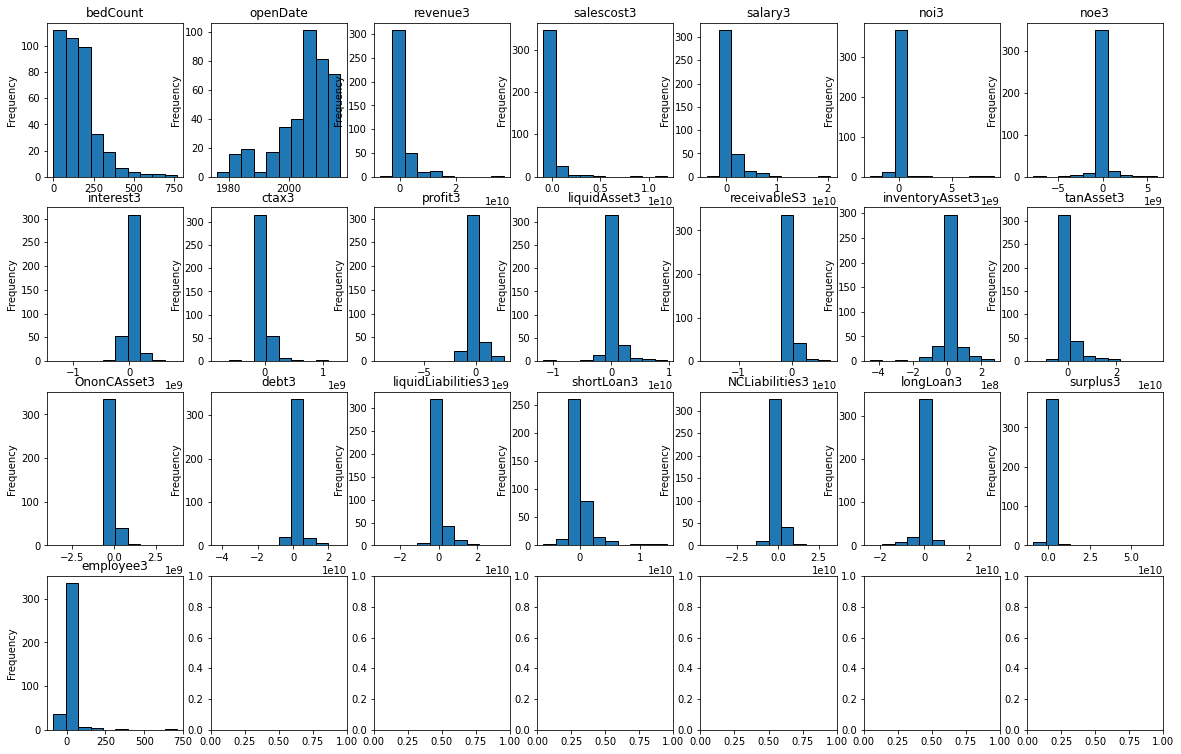

In [ ]:
# 히스토그램을 이용하여 open의 수치형 데이터 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,7)

fig.set_size_inches((20,13))
for var, subplot in zip(list_col,ax.flatten()):

  df4_open[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

In [ ]:
# open 데이터의 outlier 대치(iqr 사용)
# 1사분위와 3사분위 밖에 있는 점은 1사분위와 3사분위에 가까운 점으로 대치
def outlier_change(df, li_col):
  for i in range(0, len(li_col)):

    a = df[li_col[i]]
    weight = 1.5
    quantile_25 = np.percentile(a.values, 25)
    quantile_75 = np.percentile(a.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = list(a[(a<lowest_val)|(a>highest_val)].index)
    lowest_index = list(a[(a<lowest_val)].index)
    highest_index= list(a[(a>highest_val)].index)

    value = []

    if(len(outlier_index) != 0) : # 만약, 아웃라이어 값이 존재한다면
      for index in range(0, len(lowest_index)):
         df.loc[[lowest_index[index]],[li_col[i]]] = lowest_val
      
      for  index in range(0, len( highest_index)):
         df.loc[[ highest_index[index]],[li_col[i]]] =  highest_val

In [ ]:
outlier_change(df4_open, list_col)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

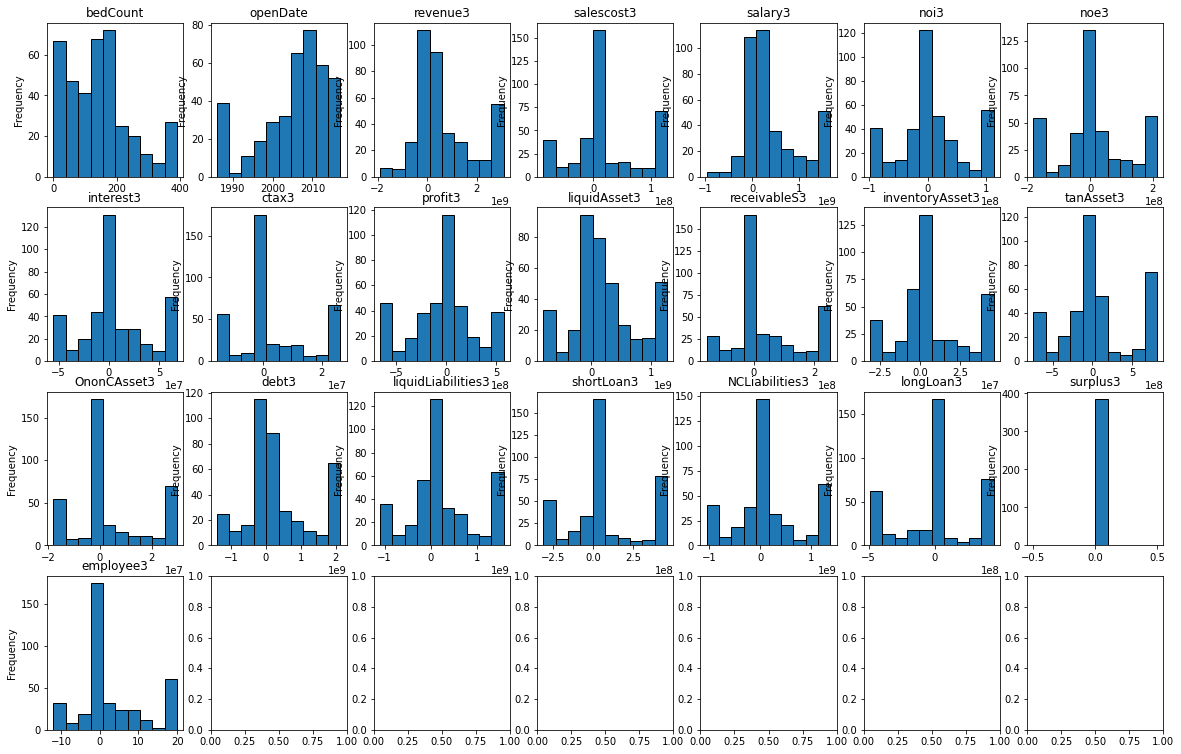

In [ ]:
# outlier 대치 후 open의 수치형 데이터 분포 확인
fig, ax = plt.subplots(4,7)

fig.set_size_inches((20,13))
for var, subplot in zip(list_col,ax.flatten()):

  df4_open[var].plot(kind='hist',ax=subplot, title=var, edgecolor='black')

In [ ]:
# open 데이터의 제거했던 변수 추가
add_col = df4_open_copy['OC'].values
add_col2 = df4_open_copy['sido'].values
add_col3 = df4_open_copy['instkind'].values
add_col4 = df4_open_copy['ownerChange'].values
add_col5 = df4_open_copy['sgg'].values
add_col6 = df4_open_copy['receivableL3'].values

In [ ]:
df4_open['OC'] = add_col
df4_open['sido'] = add_col2
df4_open['instkind'] = add_col3
df4_open['ownerChange'] = add_col4
df4_open['sgg'] = add_col5
df4_open['receivableL3'] = add_col6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
list(df4_open.columns)

['OC',
 'sido',
 'instkind',
 'ownerChange',
 'bedCount',
 'openDate',
 'sgg',
 'revenue3',
 'salescost3',
 'salary3',
 'noi3',
 'noe3',
 'interest3',
 'ctax3',
 'profit3',
 'liquidAsset3',
 'receivableS3',
 'inventoryAsset3',
 'tanAsset3',
 'OnonCAsset3',
 'receivableL3',
 'debt3',
 'liquidLiabilities3',
 'shortLoan3',
 'NCLiabilities3',
 'longLoan3',
 'surplus3',
 'employee3']

In [ ]:
# outlier 제거한 open 데이터와 close 데이터 병합
frames = [df4_open, df4_close]
df4_third = pd.concat(frames)
df4_third

,OC,sido,instkind,ownerChange,bedCount,openDate,sgg,revenue3,salescost3,salary3,noi3,noe3,interest3,ctax3,profit3,liquidAsset3,receivableS3,inventoryAsset3,tanAsset3,OnonCAsset3,receivableL3,debt3,liquidLiabilities3,shortLoan3,NCLiabilities3,longLoan3,surplus3,employee3
0,0,choongnam,nursing_hospital,1,175.0,2007.0,73,-8.031824e+07,0.0,-2.995207e+07,-542234.0,-14747118.0,-2446810.0,12833724.0,17339993.0,1.825302e+08,-53646830.0,1428837.0,-25579299.0,-2449000.0,0,-7.616775e+07,-2.155316e+07,0.0,-5.461460e+07,-3.900000e+07,0.0,-2.0
2,0,gyeonggi,nursing_hospital,1,392.0,2016.0,89,1.004522e+09,127739932.0,2.964023e+08,76156.0,30000.0,0.0,0.0,41864754.0,2.724421e+08,8095950.0,18759968.0,120481028.0,0.0,0,9.241434e+07,9.241434e+07,0.0,0.000000e+00,0.000000e+00,0.0,20.0
3,0,incheon,general_hospital,1,353.0,2000.0,141,3.082989e+09,0.0,1.659052e+09,29415255.0,-94104842.0,-55352210.5,-15883957.5,64442822.0,1.275637e+09,0.0,45636891.5,814847980.5,29302018.0,0,2.129946e+09,1.576245e+09,460148219.0,-1.051356e+09,-4.905037e+08,0.0,0.0
4,0,gyeongnam,general_hospital,1,196.0,2005.0,32,9.607370e+08,0.0,1.000740e+09,-98141328.0,-103018625.0,-42602315.0,0.0,48107111.0,1.275637e+09,252709845.0,1059446.0,-745053503.5,-17865000.0,0,-1.409470e+09,-1.101214e+09,336623138.0,-3.710896e+08,-4.905037e+08,0.0,9.0
5,0,gyeongnam,general_hospital,1,243.0,2002.0,155,-7.539098e+08,-86185580.0,2.674107e+08,-60266829.0,213799538.5,-55352210.5,0.0,-120913329.0,7.656857e+08,252709845.0,9862851.0,-745053503.5,-17865000.0,0,0.000000e+00,-1.101214e+09,93390000.0,-2.000000e+07,0.000000e+00,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,busan,nursing_hospital,1,151.0,2010.0,66,-2.244973e+09,-650410974.0,-9.824096e+08,-2467843.0,78026204.0,-54489520.0,-1340130.0,-60576116.0,-6.259562e+07,-8798366.0,-1637000.0,-137705707.0,-11956000.0,0,1.586852e+07,1.586852e+07,0.0,0.000000e+00,0.000000e+00,0.0,0.0
423,1,jeonnam,traditional_clinic,1,0.0,2001.0,33,-6.478885e+07,-742841.0,9.335632e+08,-59818683.0,-269660838.0,-153130496.0,-137857554.0,-153873997.0,1.204736e+09,644261571.0,39237644.0,926325081.0,2000000.0,0,1.951897e+08,-2.207433e+07,0.0,2.172640e+08,0.000000e+00,0.0,10.0
424,1,gyeonggi,traditional_hospital,1,151.0,2001.0,74,-7.759709e+08,0.0,-4.263722e+08,-9779723.0,-53108189.0,-35378688.0,528685902.0,-615322508.0,-8.826843e+08,-133178510.0,0.0,518737744.0,106220000.0,0,-1.237918e+09,5.165253e+08,0.0,-1.754443e+09,-1.740000e+09,980191435.0,-5.0
425,1,gyeonggi,hospital,1,150.0,2001.0,116,1.170330e+09,96884054.0,6.235152e+08,-98769400.0,50608589.0,157710291.0,517770.0,42113908.0,0.000000e+00,0.0,0.0,0.0,0.0,0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,10.0


## 3.12 스케일링




###-dummy 변수 생성
- sido와 instkind를 dummy 변수로 생성

In [ ]:
# sido : level 17개 -> dummy변수 생성 
# instkind  : level 8개 -> dummy변수 생성
df5_third = pd.get_dummies(df4_third)

In [ ]:
# 열 개수 : dummy변수로 인해 55개로 증가
df5_third.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 427
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OC                             418 non-null    int64  
 1   ownerChange                    418 non-null    int64  
 2   bedCount                       418 non-null    float64
 3   openDate                       418 non-null    float64
 4   sgg                            418 non-null    int64  
 5   revenue3                       418 non-null    float64
 6   salescost3                     418 non-null    float64
 7   salary3                        418 non-null    float64
 8   noi3                           418 non-null    float64
 9   noe3                           418 non-null    float64
 10  interest3                      418 non-null    float64
 11  ctax3                          418 non-null    float64
 12  profit3                        418 non-null    flo

###-Minmax


In [ ]:
y = df5_third['OC']
X = df5_third.drop('OC', axis=1)

In [ ]:
# MinMaxScaler 적용
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

MMS = MinMaxScaler()
MMS.fit(X)
X_mms = MMS.transform(X)
X_mms_pd = pd.DataFrame(X_mms, columns=X.columns)
X3 = X_mms_pd

##3.13 모델링

In [ ]:
X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ownerChange                    418 non-null    float64
 1   bedCount                       418 non-null    float64
 2   openDate                       418 non-null    float64
 3   sgg                            418 non-null    float64
 4   revenue3                       418 non-null    float64
 5   salescost3                     418 non-null    float64
 6   salary3                        418 non-null    float64
 7   noi3                           418 non-null    float64
 8   noe3                           418 non-null    float64
 9   interest3                      418 non-null    float64
 10  ctax3                          418 non-null    float64
 11  profit3                        418 non-null    float64
 12  liquidAsset3                   418 non-null    flo

In [ ]:
# test_size = 0.25 / train_size = 0.75
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y,test_size = 0.25,random_state = 100, stratify=y)


###-오버샘플링
 - 종속변수인 'OC' 데이터의 close 데이터가 상당히 부족하여 오버샘플링 실시

In [ ]:
# train 데이터 오버샘플링
smote = SMOTE(random_state=0)
X3_train_over,y3_train_over = smote.fit_sample(X3_train,y3_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X3_train.shape, y3_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X3_train_over.shape, y3_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y3_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (313, 50) (313,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (576, 50) (576,)
SMOTE 적용 후 레이블 값 분포: 
 1    288
0    288
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# gboost 사용을 위한 X's train, test numpy 변경
import numpy as np
X3_train_over = np.array(X3_train_over)
X3_test = np.array(X3_test)

###-하이퍼파라미터 튜닝
 - 그리드서치를 통한 모델의 최적 파라미터 찾기

In [ ]:
################# KNN #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

knn = KNN()
knn_parameters = {'n_neighbors':[3,5,7], 'metric':['eucldiean', 'manhattan', 'chebyshev','minkowski','wminkowski', 'seuclidean','mahalanobis']}
knn_grid = GridSearchCV(knn, param_grid=knn_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
knn_grid.fit(X3_train_over, y3_train_over)
# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df_knn = pd.DataFrame(knn_grid.cv_results_)
scores_df_knn[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'eucldiean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Metric 'eucldiean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Value

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'metric': 'eucldiean', 'n_neighbors': 3}",NaN,15,NaN,NaN,NaN
1,"{'metric': 'eucldiean', 'n_neighbors': 5}",NaN,19,NaN,NaN,NaN
2,"{'metric': 'eucldiean', 'n_neighbors': 7}",NaN,18,NaN,NaN,NaN
3,"{'metric': 'manhattan', 'n_neighbors': 3}",0.996528,3,1.000000,1.000000,0.989583
4,"{'metric': 'manhattan', 'n_neighbors': 5}",0.989583,5,0.989583,1.000000,0.979167
5,"{'metric': 'manhattan', 'n_neighbors': 7}",0.986111,6,1.000000,1.000000,0.958333
6,"{'metric': 'chebyshev', 'n_neighbors': 3}",0.982639,7,0.989583,0.989583,0.968750
7,"{'metric': 'chebyshev', 'n_neighbors': 5}",0.982639,7,0.989583,0.968750,0.989583
8,"{'metric': 'chebyshev', 'n_neighbors': 7}",0.979167,9,0.968750,0.979167,0.989583
9,"{'metric': 'minkowski', 'n_neighbors': 3}",1.000000,1,1.000000,1.000000,1.000000


In [ ]:
################# LogisticRegression #################
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold

lr_clf = LogisticRegression(random_state=10)
params = {
    'C' : np.arange(0, 1, 0.1)
}
skfold = StratifiedKFold(n_splits = 10)
grid_cv = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=skfold, verbose=1)
grid_cv.fit(X3_train_over, y3_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
model = grid_cv.best_estimator_
score = model.score(X3_test, y3_test)
print('테스트세트에서의 정확도 수치: {:.4f}'.format(score))
print("테스트 세트 AUC: {:.4f}".format(roc_auc_score(y3_test, grid_cv.decision_function(X3_test))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:935: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1. / C, sample_weight),
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:124: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + .5 * alpha * np.dot(w, w)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:129: RuntimeWarning: invalid value encountered in multiply
  grad[:n_features] = safe_sparse_dot(X.T, z0) + alpha * w
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/usr/local/l

Fitting 10 folds for each of 10 candidates, totalling 100 fits
GridSearchCV 최고 평균 정확도 수치: 0.8489
GridSearchCV 최적 하이퍼파라미터:  {'C': 0.8}
테스트세트에서의 정확도 수치: 0.7810
테스트 세트 AUC: 0.7010


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


In [ ]:
################# DecisionTreeClassifier #################
# 하이퍼파라미터튜닝 - GridSearchCV

from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
dt_parameters = {'max_depth':[2,3,4,5], 'min_samples_split':[2,3]}
dt_grid = GridSearchCV(dt, param_grid=dt_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
dt_grid.fit(X3_train_over, y3_train_over)
# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df_s = pd.DataFrame(dt_grid.cv_results_)
scores_df_s[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 2, 'min_samples_split': 2}",0.621528,7,0.541667,0.531250,0.791667
1,"{'max_depth': 2, 'min_samples_split': 3}",0.621528,7,0.541667,0.531250,0.791667
2,"{'max_depth': 3, 'min_samples_split': 2}",0.687500,5,0.666667,0.677083,0.718750
3,"{'max_depth': 3, 'min_samples_split': 3}",0.687500,5,0.666667,0.677083,0.718750
4,"{'max_depth': 4, 'min_samples_split': 2}",0.809028,3,0.739583,0.843750,0.843750
5,"{'max_depth': 4, 'min_samples_split': 3}",0.809028,3,0.739583,0.843750,0.843750
6,"{'max_depth': 5, 'min_samples_split': 2}",0.843750,1,0.812500,0.854167,0.864583
7,"{'max_depth': 5, 'min_samples_split': 3}",0.843750,1,0.812500,0.854167,0.864583


In [ ]:
################# svc #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
import sklearn.svm as svm

lr_clf = svm.SVC()
params = {
    'C' : range(1,100,10)
}
skfold = StratifiedKFold(n_splits = 10)
grid_cv = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=skfold, verbose=1)
grid_cv.fit(X3_train_over, y3_train_over)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
model = grid_cv.best_estimator_
score = model.score(X3_test, y3_test)
print('테스트세트에서의 정확도 수치: {:.4f}'.format(score))
print("테스트 세트 AUC: {:.4f}".format(roc_auc_score(y3_test, grid_cv.decision_function(X3_test))))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.9792
GridSearchCV 최적 하이퍼파라미터:  {'C': 31}
테스트세트에서의 정확도 수치: 0.9143
테스트 세트 AUC: 0.6340


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [ ]:
################# xgb #################
# 하이퍼파라미터튜닝 - GridSearchCV

from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
xgb_parameters = {'n_estimators':[100,200,400,600], 'learning_rate':[0.01,0.05,0.1,0.15,0.2], 'max_depth':[4,6,8]}
xgb_grid = GridSearchCV(xgb, param_grid=xgb_parameters,scoring=make_scorer(recall_score),  cv=3, refit=True)
xgb_grid.fit(X3_train_over, y3_train_over)
print('최적 하이퍼 파라미터: ', xgb_grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(xgb_grid.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 600}
최고 예측 정확도: 0.9896


In [ ]:
################# random forest #################
# 하이퍼파라미터튜닝 - GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = { 'n_estimators' : [10, 100],
           'max_depth' : [4, 6, 8],
           'min_samples_leaf' : [10, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X3_train_over, y3_train_over)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9826


###-모델 적용
- KNN, LogisticRegression, Decision Tree, SVM, Xgboost, Random Forest

In [ ]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier as KNN
model_KNN = KNN(n_neighbors=3, metric="minkowski") 
model_KNN.fit(X3_train_over, y3_train_over)
knn_pred = model_KNN.predict(X3_test)

# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=5, min_samples_split=2)
dt_clf.fit(X3_train_over, y3_train_over)
dt_pred = dt_clf.predict(X3_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=13, solver='liblinear', C=0.8)
lr_clf.fit(X3_train_over, y3_train_over)
lr_pred = lr_clf.predict(X3_test)

# SVM
import sklearn.svm as svm
import sklearn.metrics as mt
l_svm_clf = svm.SVC(C=31, kernel = 'linear')
l_svm_clf.fit(X3_train_over, y3_train_over)
l_svm_pred = l_svm_clf.predict(X3_test)

# Xgboost
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=600, learning_rate=0.05, max_depth = 8)
xgb_clf.fit(X3_train_over, y3_train_over)
xgb_pred = xgb_clf.predict(X3_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf1 = RandomForestClassifier(n_estimators = 100,
                                max_depth = 6,
                                min_samples_leaf = 10,
                                min_samples_split = 8,
                                random_state = 100,
                                n_jobs = -1)
rf_clf1.fit(X3_train_over, y3_train_over)
rf_clf1_pred = rf_clf1.predict(X3_test)


models_3 = [model_KNN, dt_clf, lr_clf, l_svm_clf, xgb_clf, rf_clf1]
model_names_3 = ['KNN','DecisionTree', 'LogisticReg', 'SVM', 'Xgboost', 'Random Forest']

results_3 = get_result_pd(models_3, model_names_3, X3_train_over, y3_train_over, X3_test, y3_test)
results_3

,accuracy,precision,recall,f1,roc_auc
KNN,0.828571,0.187500,0.375,0.250000,0.620490
DecisionTree,0.914286,0.461538,0.750,0.571429,0.838918
LogisticReg,0.790476,0.181818,0.500,0.266667,0.657216
SVM,0.847619,0.250000,0.500,0.333333,0.688144
Xgboost,0.980952,1.000000,0.750,0.857143,0.875000
Random Forest,0.990476,1.000000,0.875,0.933333,0.937500


#4.결과 해석

##4.1 confusion matrix

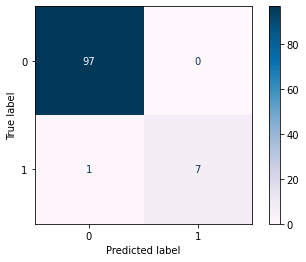

In [ ]:
# roc_auc가 가장 높은 'Random Forest'의 confusion matrix
from sklearn.metrics import *
plot_confusion_matrix(rf_clf1, X3_test, y3_test, cmap='PuBu')

In [ ]:
print(classification_report(y3_test, rf_clf1_pred, target_names =['Open', 'Close']))

              precision    recall  f1-score   support

        Open       0.99      1.00      0.99        97
       Close       1.00      0.88      0.93         8

    accuracy                           0.99       105
   macro avg       0.99      0.94      0.96       105
weighted avg       0.99      0.99      0.99       105



##4.2 roc_curve 그래프 

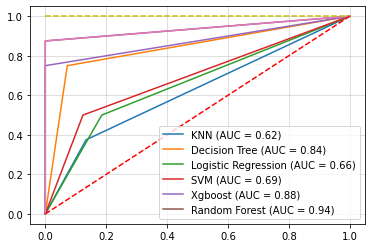

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#knn
fpr, tpr, thresholds = roc_curve(y_true = y3_test, y_score = knn_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, label='KNN (AUC = %0.2f)'% roc_auc)

#DT
fpr, tpr, thresholds = roc_curve(y_true = y3_test, y_score = dt_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, label='Decision Tree (AUC = %0.2f)'% roc_auc)

#LR
fpr, tpr, thresholds = roc_curve(y_true = y3_test, y_score = lr_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)'% roc_auc)

#SVM
fpr, tpr, thresholds = roc_curve(y_true = y3_test, y_score = l_svm_pred)

roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, label='SVM (AUC = %0.2f)'% roc_auc)

#Xgboost
fpr, tpr, thresholds = roc_curve(y_true = y3_test, y_score = xgb_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, label='Xgboost (AUC = %0.2f)'% roc_auc)

#Random Forest
fpr, tpr, thresholds = roc_curve(y_true = y3_test, y_score = rf_clf1_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)'% roc_auc)


roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr)

plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')
plt.grid(alpha = 0.5)

plt.legend(loc='lower right')
plt.show()

##4.3 가설 검정( Decision Tree로 살펴본 feature 중요도) 
- 목차 2.5에서 세운 가설 검정 :


1.   Ownerchange(대표자의 변동 여부)이 병원 개/폐업에 영향을 미칠 것이다. -> 기각

2.   2016년 대비 2017년의 profit(당기순이익)의 변동성이 병원 개/폐업에 영향을 미칠 것이다. -> 기각
3.   2016년 대비 2017년의 debt(부채총계)의 변동성이 병원 개/폐업에 영향을 미칠 것이다. -> 기각
4.   2016년 대비 2017년의 interest(이자비용)의 변동성이 병원 개/폐업에 영향을 미칠 것이다. -> 채택
5.   employee(직원수)의 증감이 병원 개/폐업에 영향을 미칠 것이다.-> 기각


- 새로운 사실, 반응 변수에 중요한 영향을 미치는 변수 
1.  2016년 대비 2017년의 inventoryAsset(재고자산)의 변동성 -> 'inventoryAsset3'
2.  2016년 대비 2017년의 OnonCAsset(기타비유동자산)의 변동성 -> 'OnonCAsset3'
3.  2016년 대비 2017년의 revenue(매출액)의 변동성 -> 'revenue3'


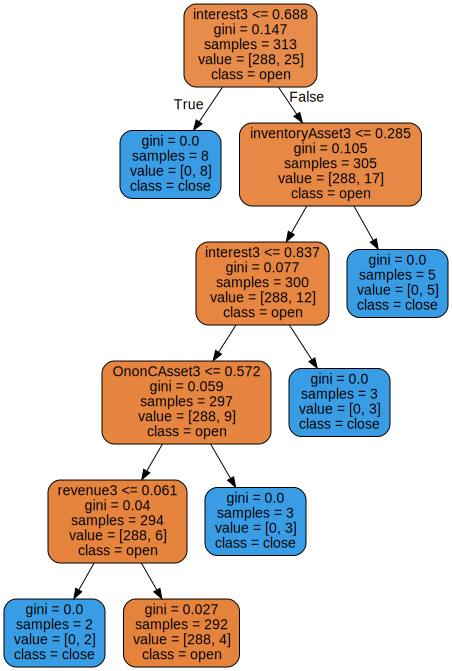

In [ ]:
# DecisionTree picture
dt = DecisionTreeClassifier(max_depth = 5, random_state= 10)
dt.fit(X3_train, y3_train)

pred = dt.predict(X3_test)

Source(export_graphviz(dt, feature_names=X3.columns, class_names=['open', 'close'], rounded=True, filled=True))